# Forschungsprojekt B

#  PubMedMA: Erstellung einer Datenbank für Meta-Analysen mithilfe eines Large Language Models

## Nutzung von LLM für die Auswertung von medizinischen Paper für Meta-Analysen

## Einleitung

In diesem Projekt wird ein Large Language Model (LLM) genutzt, um Informationen aus PubMed-Papers systematisch zu extrahieren und als strukturierte Medical Records in einer Datenbank (DB) zu speichern. Diese Datenbank ermöglicht umfassende Meta-Analysen von medizinischen Studien, um effizientere und robustere Erkenntnisse zu Krankheiten, Medikamenten und Therapien zu gewinnen. Der Einsatz von LLM automatisiert die Datenextraktion und -strukturierung, wodurch eine schnelle und präzise Analyse großer Datenmengen ermöglicht wird. Dadurch werden Forschungsprozesse optimiert und die Entwicklung neuer medizinischer Behandlungsstrategien beschleunigt.

Das Abstract, die Anleitung, die Ergebnisse samt Diskussion sowie Fazit und Ausblick befinden sich im Paper mit dem Titel PubMedMA_Abschlusspaper.pdf. Dieses Dokument ist ebenso in diesem Repository zu finden und in der Abgabe.

Es beinhaltet alle wichtigen Informationen und beschreibt und diskutiert das Projekt und die Ergebnisse ausführlich. Zum Verständnis sollte dieses Paper gelesen werden. Allein dieses Notebook reicht nicht aus. Es dient lediglich als Ergänzung mit technischen Details.

In diesem Notebook wird lediglich die Implementierung und der Prozess beschrieben. Der Fokus liegt hier darauf wie es gemacht wurde und welche Gedanken mit reingespielt haben.

Um dieses Notebook lokal laufen zu lassen muss über OLLaMa LLaMa3 8B heruntergeladen und gestartet werden. (https://ollama.com/)

Auch soll es als Dokumentation für den Code dienen.

### Prozess
Zur Realisierung des Projekts wurden die notwendigen Schritte geplant und visualisiert als Orientierung für die Entwicklung. Die folgende Abbildung zeigt den Prozess und die Schritte des Projekts und Implementierung ab, der wie folgt abläuft:
1. Zuerst werden mit PyMed und metapub relevante Publikationen bzw. Papers gelesen. Relevant sind die Paper, die Resultate haben (results) und Medikationsgruppen getestet haben. Diese Paper sind auf einer Datenbank in PubMed gespeichert, welche von NCBI frei zur Verfügung gestellt wird
2. Dann werden die Daten lokal vorbereitet, in dem sie strukturiert und gesäubert werden
3. Die Daten werden über mehrere Prompts analysiert mithilfe von LLaMa3 mit 8 Milliarden Parameter
4. Diese sendet dann Antworten zurück in Form von JSON
5. Diese Daten werden abschließend in einer PostgreSQL Datenbank persistiert, die lokal in einem Docker Container läuft

![Pictures/fpb_architektur.png](Pictures/fpb_architektur.png)

In diesem Jupyter Notebook werden nun alle Schritte und Skripte zur Umsetzung des Projekts implementiert und dokumentiert.

Ein Projekt von Niko Kauz - BAM SoSe 2024

Forschungsprojekt B - Bei Prof. Dr. Peter Schanbacher

An der Hochschule Furtwangen University

Im Studiengang Business Application Architecture Master

An der Fakultät Wirtschaftsinformatik

## Development

### Imports

Laden der für das Projekt notwendigen Bibliotheken.

Der erste Block lädt die besonderen Bibliotheken runter.

In [495]:
# Wenn einige Bibliotheken nicht importiert werden können, installiere sie bitte mit pip
import sys
!{sys.executable} -m pip install -U --force-reinstall llama-cpp-python --no-cache-dir
!{sys.executable} -m pip install llama_index
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pymed
!{sys.executable} -m pip install metapub
!{sys.executable} -m pip install alive-progress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 410.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 281.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 511.9 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 260.7 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 572.0 kB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 369.9 kB/s eta 0:00:00a 0:00:01


In [226]:
# LLaMa Imports
from llama_cpp import Llama
from llama_index.core import SimpleDirectoryReader

# BERT Transformer
from transformers import BertTokenizer, BertModel
import torch

# Visualization
import matplotlib.pyplot as plt

# Misc
from collections import defaultdict
import json
import pandas as pd
import openpyxl
import os
import requests
import re
import time
import datetime
import numpy as np
from datetime import datetime
from alive_progress import alive_bar

# PyMed
from pymed import PubMed

# PubMed
import metapub

# Postgres
import psycopg2

print("Imports done")

Imports done


## Data Collection

Im folgenden wird beschrieben wie die Daten von PubMed gesammelt, vorbereitet und persistiert werden.

### Auswahl der Bibliothek zum Sammeln der Daten

Zum Lesen der Papers auf PubMed gibt es mehrere Libraries und Wrapper, die die API von NCBI nutzen. Dies bietet den Vorteil von schon, dass es schon Handler für die Sammlung der Daten gibt und diese nicht selbst programmiert werden müssen. Die drei meist genutzten sind PyMed, metapub und Entrez von Biopython (einer bekannten Sammlung von Tools und Libraries für Aufgaben im Bio- und Chemie-Bereich). Im folgenden werden sie kurz vorgestellt und analysiert, um abschließend die Library ausgewählt, die in diesem Projekt verwendet wird.

#### PyMed

PyMed ist eine Python-Bibliothek, die eine einfache Schnittstelle zur PubMed API bietet. Sie ermöglicht das Suchen und Abrufen von PubMed-Datensätzen.

Vorteile:
- Einfache und intuitive Nutzung
- Leichte Installation und Konfiguration
- Gute Dokumentation und Beispiele

Nachteile:
- Eingeschränkte Funktionalität im Vergleich zu umfassenderen Bibliotheken
- Weniger flexibel für komplexe Abfragen

#### metapub

metapub ist eine umfassende Python-Bibliothek, die verschiedene NCBI-APIs abdeckt, einschließlich PubMed. Sie bietet fortgeschrittene Funktionen für das Abrufen und Verarbeiten von wissenschaftlichen Publikationen.

Vorteile:
- Umfassende Funktionalität, deckt mehrere NCBI-APIs ab
- Flexibilität bei der Durchführung komplexer Abfragen
- Unterstützung für die Arbeit mit verschiedenen Datenquellen (z.B. PubMed, PMC, DOI)

Nachteile:
- Komplexer in der Nutzung und Konfiguration
- Steilere Lernkurve im Vergleich zu einfacheren Bibliotheken

#### Bio.Entrez (Teil des Biopython-Pakets)

Bio.Entrez ist ein Modul innerhalb des Biopython-Pakets, das eine Schnittstelle zur NCBI-Entrez-Datenbank bietet, einschließlich PubMed. Es ist Teil einer größeren Suite von Bioinformatik-Tools.

Vorteile:
- Teil des umfassenden Biopython-Pakets, das viele Bioinformatik-Tools bietet
- Hohe Flexibilität und Anpassungsfähigkeit
- Unterstützt eine breite Palette von NCBI-Datenbanken

Nachteile:
- Einarbeitung in Biopython erforderlich
- Komplexer für einfache Abfragen
- Abhängigkeit von einem größeren Paket, was für spezifische Anwendungen überdimensioniert sein kann


Die Wahl der richtigen Bibliothek hängt stark von den spezifischen Anforderungen und dem Erfahrungsniveau des Benutzers ab:

- Für einfache und schnelle Abfragen: PyMed ist am besten geeignet aufgrund seiner Benutzerfreundlichkeit und einfachen Handhabung.
- Für umfassendere und komplexe Abfragen: metapub bietet eine gute Balance zwischen Funktionalität und 
- Für Nutzer, die eine breite Palette von Bioinformatik-Tools benötigen: Bio.Entrez (Biopython) ist die beste Wahl aufgrund seiner umfangreichen Funktionalität und Integration in ein größeres Ökosystem von Bioinformatik-Tools.


#### Auswahl
Die Auswahl fällt auf metapub, da es eine gute Balance zwischen Benutzerfreundlichkeit und umfassender Funktionalität bietet und sich gut für die meisten Anwendungen im Bereich der wissenschaftlichen Recherche eignet.

Außerdem liefert es im Vergleich zu PyMed mehr Daten in Abstract zurück durch die vollständige Result zurück. Bei einem Fall hat PyMed für Results nur einen Teil des Abstracts und Results geliefert, während metapub alles geliefert hat.

Kombiniert wird dies mit PyMed, da metapub keine Möglichkeit gibt für eine Query mehrere Papers mit dem kompletten Datensatz zu erhalten. Auch werden die Autoren nicht vollständig ausgeschrieben und das Datum der Veröffentlichung wird nicht genau wiedergegeben (nur das Jahr wird geliefert).

Beispiel https://pubmed.ncbi.nlm.nih.gov/34743579/:

**PyMed:** Seven hundred and seventy-seven patients were randomised (from 22 February 2019 to 29 July, 2020) and 95.1% completed the study. In the erenumab group, 10.6% discontinued medication due to adverse events compared to 38.9% in the topiramate group (odds ratio, 0.19; 95% confidence interval 0.13-0.27;

**metapub:** Seven hundred and seventy-seven patients were randomised (from 22 February 2019 to 29 July, 2020) and 95.1% completed the study. In the erenumab group, 10.6% discontinued medication due to adverse events compared to 38.9% in the topiramate group (odds ratio, 0.19; 95% confidence interval 0.13-0.27; p &lt; 0.001). Significantly more patients achieved a ≥50% reduction in monthly migraine days from baseline with erenumab (55.4% vs. 31.2%; odds ratio 2.76; 95% confidence interval 2.06-3.71; p &lt; 0.001). No new safety signals occurred.

Leider wurde keine Antwort gefunden wieso PyMed im Vergleich zu metapub nicht alle Daten liefert. Eine Vermutung liegt auf der falschen Codierung von "5% confidence interval 0.13-0.27; p &lt; 0.001)", da PyMed hier mittendrinnen einen Cut hat und hier mathematische Zeichen codiert sind.

### Attribute der gesammelten Daten

Mithilfe der metapub Library kann die PubMed Datenbank mit den Papern einfach angefragt werden, um viele Daten zu erhalten. Diese Daten werden innerhalb von Attributen strukturiert, von denen es einige gibt. Nicht alle Attribute werden in diesem Projekt benötigt. Die folgende Tabelle zeigt auf und beschreibt welche hier verwendet werden. Nicht alle Attribute sind immer befüllt, so können **results** und **conclusions** leer (null) sein. Dies zeigt sich jedoch nicht in der Antwort, da **results** und **conclusions** Teil des **abstract** Attributs sind und von dort extrahiert werden.

In PyMed sind diese zwei eigene Attribute, die in einer Antwort als eigene Teile zurückgegeben werden, da es jedoch ein Problem mit der Vollständigkeit der Daten gibt wird das Rauslesen und Speichern der Attribute **results** und **conclusions** manuell durchgeführt.
 
| Attribut | Beschreibung |
| --- | :----------- |
| **pubmed_id** | Ein eindeutiger Identifikator (ID) für jedes Paper in der PubMed-Datenbank. Diese ID wird verwendet, um ein spezifisches Paper eindeutig zu identifizieren und zu referenzieren. |
| **papername** | Der Titel des Peer-reviewed und veröffentlichten Papers. Dieser Titel gibt eine kurze und prägnante Beschreibung des Hauptthemas oder der Forschung des Papers. |
| **authors** | Die Liste der Autoren, die an der Erstellung des Papers beteiligt waren. Diese wird oft im Format "Nachname, Vorname; Nachname, Vorname" dargestellt und gibt die Namen der beteiligten Forscher an. |
| **publication_date** | Das Datum, an dem das Paper veröffentlicht wurde. Dieses Datum gibt an, wann die Forschung offiziell in einem Journal veröffentlicht und der wissenschaftlichen Gemeinschaft zugänglich gemacht wurde. |
| **abstract** | Eine kurze Zusammenfassung des Papers, die die wichtigsten Punkte, Methoden, Ergebnisse (results) und Schlussfolgerungen (conclusions) der Forschung enthält. Das Abstract bietet einen schnellen Überblick über den Inhalt des Papers. |
| **results** | Eine detaillierte Darstellung der Forschungsergebnisse des Papers. Dieser Abschnitt enthält die Daten, Beobachtungen und Analysen, die aus der Forschung hervorgegangen sind. |
| **conclusions** | Die Schlussfolgerungen, die aus den Forschungsergebnissen gezogen wurden. Dieser Abschnitt diskutiert die Bedeutung der Ergebnisse, ihre Implikationen und mögliche Anwendungen oder weiterführende Forschung. |
| **journal** | Der Name des wissenschaftlichen Journals, in dem das Paper veröffentlicht wurde. Das Journal gibt den Kontext und die Relevanz des Papers innerhalb eines bestimmten wissenschaftlichen Feldes an. |

### Implementierung

Die Suche und das Erhalten von mehreren Papern ist über PyMed deutlich einfacher. Deswegen läuft der Schritt zum  Sammeln der Daten wie folgt ab: 

1. Erst werden über eine Query über PyMed die "Rohdaten" angefragt mit der PMID (ID für jedes Paper in PubMed), den Autoren und Datum der Veröffentlichung. 
2. Mit metapub werden dann über die PMID die vollständigen Daten angefragt und verarbeitet. Dazu gehören Abstract, Ergebnisse und Schlussfolgerungen.
3. Die Daten werden miteinander gemerged und gespeichert.


Gespeichert werden die Daten in einem Dataframe und einer loaklen JSON Datei, sodass nicht ständig die PubMed API angefragt wird, da diese nur eine bestimmte Anzahl an Requests pro Minute zulässt (3 ohne API-Key, 10 mit API-Key). Außerdem sollen so auch die Daten lokal ohne Internetverbindung weiterverwendet werden.

In [5]:
# Set Parameters to communicate with PubMed API
# Note that the parameters are not required but kindly requested by PubMed Central
pubmed = PubMed(tool="PumMedMA", email="my@email.address")

Funktion zum Extrahieren von Conclusion und Results aus dem Abstract.

In [6]:
def extract_attributes(abstract):

    # Define pattern to extract RESULTS part of abstract
    results_pattern = re.compile(r'RESULTS:(.*?)(?=(?:[A-Z]+:|$))', re.DOTALL | re.IGNORECASE)
    
    # Define pattern to extract CONCLUSIONS part of abstract
    conclusions_pattern = re.compile(r'CONCLUSIONS:(.*?)(?=(?:[A-Z]+:|$))', re.DOTALL | re.IGNORECASE)

    # Search section matching the patterns
    results_section = results_pattern.search(abstract)
    conclusions_section = conclusions_pattern.search(abstract)
    
    # Extract section
    results = results_section.group(1).strip()
    
    # Test if conclusion is set, else set it to None
    if conclusions_section:
        conclusions = conclusions_section.group(1).strip()
    else:
        conclusions = None
    
    return results, conclusions

fetch = metapub.PubMedFetcher()
article = fetch.article_by_pmid('34743579')

abstract = article.abstract

results, conclusions = extract_attributes(abstract)

print(results)
print()
print(conclusions)

Seven hundred and seventy-seven patients were randomised (from 22 February 2019 to 29 July, 2020) and 95.1% completed the study. In the erenumab group, 10.6% discontinued medication due to adverse events compared to 38.9% in the topiramate group (odds ratio, 0.19; 95% confidence interval 0.13-0.27; p &lt; 0.001). Significantly more patients achieved a ≥50% reduction in monthly migraine days from baseline with erenumab (55.4% vs. 31.2%; odds ratio 2.76; 95% confidence interval 2.06-3.71; p &lt; 0.001). No new safety signals occurred.

Erenumab demonstrated a favourable tolerability and efficacy profile compared to topiramate.Trial


Die folgende Funktion holt sich den Abstract von einem Paper über metapub mithilfe der pubmed_id, die als Input-Parameter mitgegeben wird.

In [7]:
def propagate_metapub_data_for_analysis(pmid):
    fetch = metapub.PubMedFetcher()
    article = fetch.article_by_pmid(pmid)
    abstract = article.abstract
    
    return abstract

print(propagate_metapub_data_for_analysis('39030528'))

BACKGROUND: Migraine is one of the most common diseases worldwide while current treatment options are not ideal. New therapeutic classes of migraine, the calcitonin gene-related peptide (CGRP) antagonists, have been developed and shown considerable effectiveness and safety. The present study aimed to systematically evaluate the efficacy and safety of atogepant, a CGRP antagonist, for migraine prophylaxis from the results of randomized controlled trials (RCTs).
METHODS: The Cochrane Library, Embase, PubMed and https://www.
CLINICALTRIALS: gov/ were searched for RCTs that compared atogepant with placebo for migraine prophylaxis from inception of the databases to Feb 1, 2024. Outcome data involving efficacy and safety were combined and analyzed using Review Manager Software version 5.3 (RevMan 5.3). For each outcome, risk ratios (RRs) or standardized mean difference (SMD) were calculated.
RESULTS: 4 RCTs with a total of 2813 subjects met our inclusion criteria. The overall effect estimate

Mit der nachfolgenden Funktion werden mehrere Paper über PyMed von PubMed über eine Query gelesen. Die Query und die maximale Anzahl der zurückgegebenen Paper werden über Input-Parameter mitgegeben.

In [8]:
def propagate_pymed_data_for_analysis(analysis_query, max_results):
    # Execute the query against the API
    pymed_results = pubmed.query(
        query=analysis_query,
        max_results=max_results
    )
    
    # Write articles into list and return it
    artile_list = []

    for article in pymed_results:
        article_dict = article.toDict()
        artile_list.append(article_dict)

    print(datetime.datetime.now(), ": Read data from PubMed")

    return artile_list

Diese Funktion sammelt im Batch Daten von PubMed über PyMed, filtert die relevanten Paper (mit Resultaten) raus und holt über metapub das Abstract für das Paper. Die Autoren werden als ein String codiert. Die Paper werden in ein Dataframe gepackt und zurückgegeben.

In [9]:
def create_articles_dataframe(analysis_query, max_results):
    
    # Query PyMed and get specified number of papers for a query 
    articles = propagate_pymed_data_for_analysis(analysis_query, max_results)
    article_info = []
    run_counter = 0
    
    # Iterate through found papers
    for article in articles:
        
        print("Run Number:", run_counter+1)
        run_counter += 1
        print()
        
        # Filter papers out without an abstract and results
        if article['abstract'] is None:
            continue
            
        try:
            if article['results'] is None:
                continue
        except:
            continue
        
        # Get data from PyMed answer
        pubmed_id = article['pubmed_id'].partition('\n')[0]
        papername = article['title']
        publication_date = article['publication_date']
        
        # Format authors for full name (and credit where credit is due)
        authors = article['authors']
        authors_string = '; '.join([f"{author['lastname']}, {author['firstname']}" for author in authors])
        
        # Get journal if exists
        try:
            journal = article['journal']
        except:
            journal = None
        
        # Get abstract, results and conclusions with metapub
        abstract = propagate_metapub_data_for_analysis(pubmed_id)
        results, conclusions = extract_attributes(abstract)
        
        # Test if medication groups are tested in paper with LLaMa3        
        answer = get_answer_if_groups_tested(abstract)
        
        # Save data of paper as an dictionary in list
        article_info.append({
            u'pubmed_id': pubmed_id,
            u'papername': papername,
            u'authors': authors_string,
            u'publication_date': publication_date,
            u'abstract': abstract,
            u'results': results,
            u'conclusions': conclusions,
            u'journal': journal,
            u'medication_group_tested': answer
        })
        
        print("Run done")
        print("-----------------------------------------------------------------------------------------------")
        print()
    
    # Create dataframe from list and return it
    articles_df = pd.DataFrame.from_dict(article_info)

    print(datetime.datetime.now(), ": Dataframe created")

    return articles_df

#### Collect the data

**Run this command block initially, in best case only once**

Dieser Block erstellt einen Master Dataframe, der die Initial-Daten aus dem ersten Run hat. Hierfür können die Parameter Query und Resultate angepasst werden. Diese steuern welche Daten angefragt werden und wie viele erhalten werden.

In [636]:
# Query for diseases field
analysis_query = "migraine"

max_results = 10

In [637]:
master_df = create_articles_dataframe(analysis_query, max_results)

2024-07-22 09:42:19.474461 : Read data from PubMed
Run Number: 1


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any group, medication or therapy groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: The objectives of this real-life study were to analyze the reversion of chronic migraine (CM) to episodic migraine (EM) with fremanezumab, evaluate its benefit on the symptomatology, and determine the influence of possible clinical features on the reversion.
BACKGROUND: The clinical manifestations of CM have a high impact on the quality of life of patients, and monoclonal antibodies such as fremanezumab are used as prophylactic treatment.
METHODS: Diagnosed CM patients treated for at least 3 months with monthly fremanezumab were interviewed. The data to assess efficacy were before treatment and at the time of the inte

No.

Run done
-----------------------------------------------------------------------------------------------

Run Number: 7

Run Number: 8

Run Number: 9


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any group, medication or therapy groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Mild traumatic brain injury (TBI) affects a significant number of military personnel, primarily because of physical impact, vehicle incidents, and blast exposure. Post-traumatic headache (PTH) is the most common symptom reported following mild TBI and can persist for several years. However, the current International Classification of Headache Disorders lacks phenotypic characterization for this specific headache disorder. It is important to appropriately classify the headache sub-phenotypes as it may enable more targeted manage

In [189]:
print(master_df)

   pubmed_id                                          papername  \
0   39030528  Efficacy and safety of atogepant, a small mole...   
1   39030417  A Retrospective Analysis of Disease Epidemiolo...   
2   39028222  Evaluating the Phenotypic Patterns of Post-Tra...   
3   39027895  Analyzing Google Search Trends for Migraine Su...   
4   39024586  Use of medications for migraine in Aotearoa Ne...   
5   39023425  Hyperactivity of the medial thalamus in patien...   
6   39023397  Migraine epidemiology in collegiate student-at...   
7   39023388  Migraine heritability and beyond: A scoping re...   
8   39022731  Interictal widespread pressure hyperalgesia an...   
9   39021751  Open Label Pilot of Lorcaserin (a serotonin 2C...   
10  39016124  Association of Vestibular Disorders and Cognit...   
11  39015736  Quality of Popular Online Resources About Vest...   
12  39015320  Network analysis of negative emotions in patie...   
13  39015315  A thorough investigation into the correlation ..

**Run this block to propagate more data**

Für die Erstellung des ersten Dataframes wurde die Krankheit Migräne ausgewählt. Über die Website (https://www.webmd.com/migraines-headaches/migraine-treatments) konnten viele verschiedene Medikationen gefunden werden, um Migräne zu behandeln.

Die Namen der Medikamente wurden als Query verwendet um Paper zu lesen. Zusätzlich wurden Migräne und andere Krankheiten selbst gesucht und passende Paper geholt:

- Migraine: 2500 Papers angefragt
- Bronchitis: 500 Papers
- Influenza: 500 Papers
- Hepatitis: 500 Papers
- Sleep Disorders: 500 Papers
- Medikamente: Jeweils 100 Papers

Folgende Liste an Medikamenten wurde angefragt:

- Erenumab
- Topiramate
- Ergot
- Dihydroergotamine
- Sumatriptan Succinate
- Zolmitriptan
- Rizatriptan
- Celecoxib
- Naproxen
- Acetaminophen
- Aspirin
- Ibuprofen
- Frovatriptan
- Lasmiditan
- Beta-blockers
- Calcium channel blockers
- Amitriptyline
- Nortriptyline
- Gabapentin
- Valproic acid
- Atogepant
- Eptinezumab
- Fremanezumab
- Galcanezumab
- Rimegepant
- Zavegepant
- Venlafaxine
- Vuloxetine
- Valproate
- Onabotulinumtoxin A
- Anticonvulsants
- Ditan
- Paracetamol
- Triptans
- Ergotamines
- Propranolol
- Prochlorperazine
- Droperidol
- Chlorpromazine
- Metoclopramide
- Ergotamine tartrate
- Rimegepant
- Ubrogepant
- Zavegepant
- Almotriptan
- Eletriptan
- Frovatriptan
- Naratriptan
- Rizatriptan
- Sumatriptan
- Zolmitriptan

In [398]:
# Query for diseases field
analysis_query = 'migraine'

max_results = 1000

Sammeln der Daten in einem separaten Dataframe. Diese wird dann mit dem Master-Datensatz konkatiniert, wobei doppelte Einträge verworfen werden.

In [399]:
branch_df = create_articles_dataframe(analysis_query, max_results)

master_df = pd.concat([master_df, branch_df])
master_df = master_df.drop_duplicates(subset='pubmed_id', keep='first')

2024-07-21 11:30:30.017558 : Read data from PubMed
Run Number: 1


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To examine cerebral functional alterations associated with sensory processing in patients with migraine and constant photophobia.
BACKGROUND: Migraine is a common headache disorder that presents with photophobia in many patients during attacks. Furthermore, some patients with migraine experience constant photophobia, even during headache-free intervals, leading to a compromised quality of life.
METHODS: This prospective, case-control study included 40 patients with migraine (18 male and 22 female) who were recruited at an eye hospital and eye clinic. The patients were divided into two groups: migraine with photophobia group, consisting 

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 6


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: The aim of the study was to determine the heavy metal and trace element (HMTE) profile in patients with migraine (PwM) and to compare it to that of healthy individuals without migraine.
BACKGROUND: Migraine is a universal disease that affects more than 10% of the world's population; however, its pathophysiology is still obscure.
METHODS: A total of 100 participants were included in this prospective matched case-control study (50 PwM during acute attack and 50 age- and sex-matched healthy controls). The study was conducted in the university hospital in Y

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 11


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the real-world effectiveness and tolerability of calcitonin gene-related peptide (CGRP) monoclonal antibodies (mAbs) and onabotulinumtoxinA in chronic migraine (CM) patients.
METHODS: This multicenter study involved retrospective analysis of prospectively collected data of CM patients treated with CGRP mAbs or onabotulinumtoxinA, including difficult-to-treat (DTT) patients (i.e., ≥3 preventive failures). Treatment outcomes were determined at 6 months based on prospective headache diaries and Migraine Disability Assessment (MIDAS).
RESULTS: 

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 16


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: The objective are to determine whether diphenhydramine coadministered with prochlorperazine versus prochlorperazine only is associated with a difference in the risk of migraine treatment failure, as measured by the need for additional therapy, hospitalization rates, and 72-hour return rates, and to compare extrapyramidal adverse effects between groups.
METHODS: Retrospective cohort of patients aged 7 to 18 years treated in the emergency department for migraines using prochlorperazine with or without diphenhydramine between 2013 and 2019. Patients wer

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 20


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Pediatric migraine prophylaxis is indicated when headaches are frequent and/or disabling. We aimed to conduct a study to compare the efficacy of cinnarizine and amitriptyline in pediatric migraine prophylaxis.
METHODS: In a randomized, double-blind trial, patients aged 4-17 years with migraine who were eligible for prophylaxis enrolled. The primary outcome was a reduction response rate of ≥50% with p &lt; 0.005 with respect to headache characteristics. The secondary outcome was migraine disability assessment. We evaluated patients every four weeks for

Vergangene Zeit: 00:00:03
Yes.

Run done
-----------------------------------------------------------------------------------------------

Run Number: 23


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Many patients with chronic migraine do not achieve clinically meaningful improvement in their headache frequency with monotherapy. The burden associated with chronic migraine calls for a multifaceted treatment approach targeting multiple aspects of migraine pathophysiology.
OBJECTIVE: The aim of this study was to evaluate the effect of concurrent anti-calcitonin gene-related peptide (CGRP) monoclonal antibody (mAb) and onabotulinumtoxinA (onabot) treatment on median monthly migraine days (MMD) in patients with chronic migraine, through a retrospecti


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
IMPORTANCE: Patients with migraine often cycle through multiple nonspecific preventive medications due to poor tolerability and/or inadequate efficacy leading to low adherence and increased disease burden.
OBJECTIVE: To compare the efficacy, tolerability, patient adherence, and patient satisfaction between erenumab and nonspecific oral migraine preventive medications (OMPMs) in patients with episodic migraine (EM) who had previously failed 1 or 2 preventive treatments.
DESIGN, SETTING, AND PARTICIPANTS: The 12-month prospective, interventional, global, multicenter, active-controlled, randomized clinical trial comparing sustained benefit of 2 treatment paradigms (erenumab qm vs oral prophylactics) in adult episod

Vergangene Zeit: 00:00:02
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 33


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: The aim of present study is to assess postural alterations and musculoskeletal dysfunctions over all spine in patients with chronic migraine and chronic tension type headache, moreover to highlight the differences between these two forms of primary headache.
METHODS: A Cross sectional study was adopted to evaluate the musculoskeletal profile in patients with chronic migraine and with chronic tension type headache. The Bio photogrammetric evaluation was performed using the postural assessment software PAS/SAPO, while unilateral passive accessory interv

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 38


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the serum levels of 12 cytokines in migraine group, encephalitis with headache symptoms group, pneumonia without headache symptoms group and migraine subgroups to explore the cytokines associated with migraine in children and their levels.
METHODS: A total of 44 children with migraine, 27 children in the encephalitis group with headache symptoms and 44 children in the pneumonia group without headache symptoms were selected from January 2022 to August 2023 in Hebei Children's Hospital. They were all tested for serum cytokines by immunofluores

Vergangene Zeit: 00:00:02
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 42


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
PURPOSE: Some systemic medications are reported to be associated with dry eye disease (DED), yet their associations with the severity of DED signs and symptoms are not well studied. To evaluate these associations, we performed a secondary analysis of data from the DRy Eye Assessment and Management (DREAM) Study.
METHODS: Participants (N = 535) were assessed for DED signs using tear break-up time (TBUT), Schirmer testing, corneal fluorescein staining, conjunctival lissamine green staining, meibomian gland dysfunction (MGD), and tear osmolarity and DED symptoms us

Vergangene Zeit: 00:00:02
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 46


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Calcitonin gene-related peptide monoclonal antibodies (CGRP mAbs) are indicated for migraine prevention in the United States. Limited data comparing real-world treatment patterns for CGRP mAbs are available.
OBJECTIVE: To compare the treatment patterns among patients with migraine initiating galcanezumab, fremanezumab, and erenumab.
METHODS: This retrospective study included adult patients with one or more claims for a self-injectable CGRP mAb (galcanezumab, fremanezumab, or erenumab), with continuous enrollment in medical and pharmacy benefits for 1

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 51

Run Number: 52


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine is the world's second most common disabling disorder, affecting 15% of UK adults and costing the UK over £1.5 billion per year. Several costly new drugs have been approved by National Institute for Health and Care Excellence.
AIM: To assess the cost-effectiveness of drugs used to treat adults with chronic migraine.
METHODS: We did a systematic review of placebo-controlled trials of preventive drugs for chronic migraine. We then assessed the cost-effectiveness of the currently prescribable drugs included in the review: Onabotu

Vergangene Zeit: 00:00:02
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 57


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: There have been no prior trials directly comparing the efficacy of different calcitonin gene-related peptide (CGRP) antagonists for migraine prevention. Reported are the results from the first head-to-head study of two CGRP antagonists, galcanezumab (monoclonal antibody) versus rimegepant (gepant), for the prevention of episodic migraine.
METHODS: In this 3-month, double-blind, double-dummy study, participants were randomized (1:1) to subcutaneous (SC) galcanezumab 120 mg per month (after a 240 mg loading dose) and a placebo oral disintegrating tab

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 61


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Monoclonal antibodies (mAbs) targeting the Calcitonin Gene-Related Peptide (CGRP) pathway are safe and effective treatments for migraine prevention. However, the high cost of these novel therapies has led to reimbursement policies requiring patients to try multiple traditional preventives before access. In Germany, a recent change in insurance policy significantly expanded coverage for the CGRP receptor mAb erenumab, enabling migraine patients who failed just one prior prophylactic medication to receive this mAb. Here, we compare the clinical response


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine is a disorder associated with neuropeptide release, pain and inflammation. Tau protein has recently been linked to inflammatory diseases and can be influenced by neuropeptides such as CGRP, a key neurotransmitter in migraine. Here, we report serum concentrations of total-tau protein in migraine patients and healthy controls.
METHODS: In this cross-sectional study, interictal blood samples from n = 92 patients with episodic migraine (EM), n = 93 patients with chronic migraine (CM), and n = 42 healthy matched controls (HC) were studied. We assessed serum total-tau protein (t-tau) and for comparison neurofilament light chain protein (NfL), glial fibrillary acidic protein (GFAP), and ubiquitin c

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 70


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: We aimed to compare the prescribing patterns of preventive medications between pediatric and adult neurologists for young adults with migraine.
BACKGROUND: Although preventive medications are effective for adults with migraine, studies in children have failed to demonstrate similar efficacy. As a result, lifestyle modifications and non-pharmacological interventions are often emphasized in children. It is not known whether young adults are prescribed preventive medications at different rates according to whether they are cared for by an adult or pediatr

Vergangene Zeit: 00:00:02
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 75


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the clinical effect between heat-sensitive moxibustion and mild moxibustion for migraine without aura.
METHODS: A total of 54 patients with migraine without aura were randomized into an observation group (27 cases, 2 cases dropped off) and a control group (27 cases, 2 cases dropped off). The basic western medication treatment was adopted in the two groups. In the control group, mild moxibustion was applied at Shuaigu (GB 8), Fengchi (GB 20) and Yanglingquan (GB 34) on the affected side. In the observation group, the frequent acupoint areas 

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 80

Run Number: 81


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Menstrual migraine is a subtype of migraine disease that is typically more disabling, longer-lasting, and more challenging to treat. The purpose of this network meta-analysis (NMA) is to compare the relative efficacy of treatments for menstrual migraine.
METHODS: We systematically searched databases, including PubMed, EMBASE, and Cochrane, and included all eligible randomized controlled trials in the study. We conducted the statistical analysis using Stata version 14.0, based on the frequentist framework. We used the Cochrane Risk of B

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 85


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Many drugs are prescribed in relieving acute migraine attacks, we aim to compare metoclopramide with other antimigraine drugs.
METHODS: We searched online databases like PubMed, Cochrane Library, Scopus, and Web of Science till June 2022 for RCTs that compared metoclopramide alone with placebo or active drugs. The main outcomes were the mean change in headache score and complete headache relief. The secondary outcomes were the rescue medications need, side effects, nausea and recurrence rate. We qualitatively reviewed the outcomes. Then, we performed 

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 89

Run Number: 90


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: Although ocular vestibular evoked myogenic potentials (oVEMP) abnormalities have been associated with vestibular migraine (VM) in adults, no studies have evaluated this in pediatric patients with VM. oVEMP asymmetry with normal cervical VEMP (cVEMP) findings may be a reliable VM biomarker in adults. We characterize VEMP results among pediatric patients with VM and benign recurrent vertigo of childhood (BRVC), a migraine precursor, and compare these results with VEMP findings from pediatric patients with nonmigrainous vestibular diagnose

Vergangene Zeit: 00:00:02
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 94

Run Number: 95


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: We aimed to explore the application of three-dimensional (3D) quantitative scoring of endolymphatic hydrops (EH) based on gadolinium-contrast MRI in both the diagnosis and differential diagnosis of Ménière's disease (MD).
METHODS: Local threshold method based on signal intensities was used to quantitatively measure volumes, and the degree of EH was scored by 3D quantitative scoring. The receiver-operating characteristic (ROC) curve was used to compare the diagnostic efficacy of this method against conventional evaluation methods. The sc

Vergangene Zeit: 00:00:03
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 100


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Medication-overuse headache is highly prevalent in tertiary care centers. It may be a cause or consequence of the overuse of symptomatic medications for migraine attacks.
OBJECTIVE: We aimed to compare the efficacy of anti-CGRP monoclonal antibodies (mAbs) added to conventional pharmacological treatments in patients with chronic migraine (CM) and medication overuse headache (MOH).
METHODS: A cross-sectional, prospective, randomized, open study with real-world comparison groups of patients was carried out. The sample consisted of 200 patients with CM 

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 106

Run Number: 107

Run Number: 108


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Direct comparisons of the tolerability and safety of migraine preventive treatments targeting the calcitonin gene-related peptide pathway are lacking. This study aimed to compare the safety and tolerability of anti-calcitonin gene-related peptide monoclonal antibodies and gepants in migraine prevention.
METHODS: A network meta-analysis of phase 3 randomized controlled trials assessing the safety and tolerability of anti-calcitonin gene-related peptide monoclonal antibodies (erenumab, eptinezumab, fremanezumab, or gal

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 113


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine is a chronic headache manifested with attacks. Here we aimed to evaluate and compare the efficacy of 15-point Dysport injection with 31-point Xeomin injections.
MATERIALS AND METHODS: This is a randomized clinical trial performed in 2020-2021 in Isfahan on patients with refractory chronic migraine. A total number of 60 patients entered the study. The pain of patients was also determined using headache impact test (HIT) questionnaire. Patients were randomized into two groups: Group 1 underwent 31-point Xeomin injection and Group 2 underwent 1


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: Migraine headache after tension headache is the most common primary headache in children, and sleep disorders can aggravate the symptoms. Melatonin has been proposed in some studies for prophylaxis of migraine headaches. This study aimed to evaluate melatonin's effect on migraine symptoms in children with migraine headaches and sleep disorders.
MATERIALS & METHODS: In this randomized clinical trial study, all 30 children aged 5 to 15 years with migraine headaches and sleep disorders were referred to the Pediatric Neurology Clinic and enrolled. Patients were randomly divided into two equal groups; the intervention group was treated with melatonin (3 mg daily) and propranolol (1 mg/kg daily), and the c

Vergangene Zeit: 00:00:03
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 127

Run Number: 128

Run Number: 129

Run Number: 130


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Recurrent and episodic vestibular symptoms not fulfilling criteria for known episodic vestibular syndromes are named as recurrent vestibulopathy (RV). We aimed to compare the vestibular test results of RV patients with vestibular migraine (VM) and Ménière's disease (MD).
METHODS: Twenty patients with MD, 20 patients with VM, 18 patients with RV, and 20 healthy volunteers (HC) were evaluated. Pure-tone hearing thresholds (PTHTs), video head impulse test (vHIT), functional head impulse test (fHIT), a

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 135


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Greater occipital nerve surgery has been shown to improve headaches caused by nerve compression. There is a paucity of data, however, specifically regarding the efficacy of concomitant occipital artery resection. To that end, the goal of this study was to compare the efficacy of greater occipital nerve decompression with and without occipital artery resection.
METHODS: This multicenter retrospective cohort study consisted of two groups: an occipital artery resection group (artery identified and resected) and a control group (no occipital artery resec

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 141


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: Recurrent dizziness, vertigo, and imbalance, as well as nausea or vomiting, can be induced by central or peripheral vestibular pathology. Vestibular migraine (VM) is a central pathology in which migraines reciprocally interact with vestibular nuclei. Vestibular neuritis and labyrinthitis (VN/L) are peripheral diseases involving inflammation of structures in the vestibular nerve or labyrinth. Because VM and VN/L in early stages can produce similar symptoms, diagnosis may require prolonged clinical evaluation. It has been suggested that differences in a

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 148


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the clinical phenotype of patients with chronic migraine (CM) to patients with new daily persistent headache of the chronic migraine subtype (NDPH-CM).
METHODS: A study was conducted of CM (n = 257) and NDPH-CM (n = 76) from a tertiary headache center in the UK, and in the US of patients with daily CM (n = 60) and NDPH-CM (n = 22).
RESULTS: From the UK cohort, the age of first headache onset was lower in CM (mean ± SD: 16 ± 12 years) than in NDPH-CM (mean ± SD: 23 ± 14 years; p < 0.001). There was a greater number of associated migrainous 

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 158


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Refractory chronic migraine is a common and debilitating neurologic condition, affecting over 8 million people in the United States. It is associated with billions of dollars in lost productivity annually. Novel medical (anti-calcitonin gene-related peptide antibodies) and surgical treatment modalities have emerged for chronic migraine in recent years. The current study investigated the cost-utility of surgical versus medical management of refractory chronic migraine.
METHODS: A Markov cohort analysis using hybrid Monte Carlo patient simulation was 

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 163


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Migraine is a common headache disorder. Many studies have used magnetic resonance imaging (MRI) to explore the possible pathogenesis of migraine, but they have not reached consistent conclusions and lack rigorous multiple comparison correction. Thus, this study investigates the mechanisms of migraine development from the perspective of altered functional connectivity (FC) in brain regions by using data-driven and regions of interest (ROI)-based approaches.
METHODS: Resting-state functional MRI data were collected from 30 patients with migraine and 

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 168

Run Number: 169


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare maternal obstetric complications and nonelective readmissions in women with common neurologic comorbidities (WWN) vs women without neurologic disorders.
METHODS: We performed a retrospective cohort study of index characteristics and acute postpartum, nonelective rehospitalizations from the 2015-2017 National Readmissions Database using ICD-10 codes. Wald χ2 testing compared baseline demographic, hospital, and clinical characteristics and postpartum complications between WWN (including previous stroke, migraine, multiple scl

Vergangene Zeit: 00:00:02
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 179


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Hidradenitis suppurativa (HS) is a chronic autoinflammatory skin condition and is associated with several comorbidities. Previous studies report variable prevalence rates of HS, depending on the methodology. However, the exact prevalence remains unknown.
OBJECTIVES: To estimate the prevalence of HS in a large population-based cohort in the Northern Netherlands, and to compare patients with HS to the general population, investigate characteristics and identify potential associated comorbidities.
METHODS: Data were collected through a cross-sectional 

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 183


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: Since the data regarding the efficacy of greater occipital in episodic migraines are rare, we aimed to examine the efficacy of greater occipital block in the prophylaxis of episodic migraines without aura and compare different injectable drug regimens.
METHODS: In a randomized, double-blind placebo-controlled trial, adult patients suffering from episodic migraines without aura were randomized to one of the following: triamcinolone, lidocaine, triamcinolone plus lidocaine, and saline. Patients were assessed at baseline, one week, two weeks, and four we


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To describe concussion characteristics among general college students and compare postinjury outcomes to intercollegiate student athletes.
DESIGN: Retrospective cohort.
SETTING: Large university in the Southeast region of the United States.
PARTICIPANTS: A total of 179 (N=179) college students' (female=120; 67.0%; 23.9±3.9 years) and 49 athletes' (female=28, 57.1%;19.3±1.3 years) medical records were examined. Participants self-reported injury mechanism, health history information, and completed clinical assessments acutely (<7 days postinjury).
MAIN OUTCOME MEASURES: Descriptive statistics were calculated for each group. Concussion outcomes between students with and without certain health history dia

Vergangene Zeit: 00:00:03
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 191

Run Number: 192

Run Number: 193

Run Number: 194


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Migraine is mostly a female disorder because of its lower prevalence in men. Less than 20% of patients included in the available studies on migraine treatments are men; hence, the evidence on migraine treatments might not apply to men. The aims of the present study were to provide reliable information on the effectiveness of onabotulinumtoxinA (BT-A) for chronic migraine in men and to compare clinical benefits between men and women.
METHODS: We performed a pooled patient-level gender-specific anal

Vergangene Zeit: 00:00:02
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 200


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: This study aimed to compare the effect of heat and cold therapy on the intensity of nitroglycerine induced migraine type headache in cardiac inpatients.
METHODS: This randomized controlled trial was conducted on a total of 75 cardiac inpatients in three groups design (heat or cold therapy,and control group) as pre-test and post-test. Patients in the intervention group received heat or cold therapy for25 minutes, two times (at 1-hour interval), Patients in the control group did not receive any heat or cold therapy. Headache intensity was measured by t


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: To assess the sex hormone levels in young Saudi female migraineurs during a migraine attack and during pain-free periods and compare them with control subjects.
METHODS: A case-control study involving 14 Saudi female migraineurs and 21 control subjects was conducted between December 2019 and March 2020. Demographic and disease history data were collected through participant interviews. Blood samples were drawn during the migraine attack and pain-free periods.
RESULTS: Follicular (30.00±19.60; p&lt;0.001) and luteal (39.79±11.45; p=0.037) estrogen levels were significantly higher in patients with non-menstrual related migraine (NMM), while luteal testosterone levels (1.10±0.31; p=0.023) were significa

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 211

Run Number: 212


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Balance dysfunction is a complex, disabling health condition that can present with multiple phenotypes and etiologies. Data regarding prevalence, characterization of dizziness, or associated factors is limited, especially in an African American population.
PURPOSE: The aim of the study is to characterize balance dysfunction presentation and prevalence in an African American cohort, and balance dysfunction relationship to cardiometabolic factors.
RESEARCH DESIGN: The study design is descriptive, cross sectional analysis.
STUDY SAMPLE:

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 216


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Over recent years, an increasing body of literature has focused on the relationship between erectile dysfunction (ED) and migraine. However, the specific mechanism is unclear.
MATERIALS AND METHODS: We used a bioinformatic database to predict the targets and pathways associated with migraine and ED. Twenty male SD rats were randomly divided into a blank group (Group A, n = 10) and a migraine model group (Group B, n = 10). The rats in Group A were subcutaneously injected with normal saline (2 ml/kg) into the back of the neck. Rats in Group B were sub

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 223


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: Carnitine plays a significant role in fatty acid transportation in mitochondria and has been shown to have a prophylactic effect on adult migraine. The aim of this randomized controlled trial was to compare and evaluate the effects of L-carnitine supplementation versus propranolol in the prevention of pediatric migraine.
MATERIALS & METHODS: A total of 60 pediatric patients with episodic migraine were randomly allocated to 2 independent groups to receive either 50 mg/kg/day L-carnitine or 1 mg/kg/day propranolol as a prophylactic drug. Frequency, seve

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 229

Run Number: 230

Run Number: 231


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine is a clinically high incidence rate of neurovascular disease. It is a recurrent headache. It is characterized by nausea, vomiting, fear of voice, and photophobia. Nowadays, a large number of randomized controlled clinical studies have shown that Chinese patent medicine has the advantages of good curative effect and high safety in the treatment of migraine. However, due to the variety of proprietary Chinese medicines, their relative effectiveness and safety have not yet been verified. Therefore, this study wi

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 237


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Migraine pathogenesis still remains uncertain. Studies have found contradictory results regarding NO, S100B and NSE parameters in migraine patients. Therefore, in our study, we aimed to measure NO, S100B and NSE concentrations in migraine patients, compare them with the control group and find the relationship between these parameters.
MATERIALS AND METHODS: Fifty-two patients (35 women and 17 men) diagnosed with migraine according to the International Headache Classification II criteria were included in the study. 30 healthy participants without an

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 242


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Neuroleptics are commonly prescribed drugs to treat acute conditions (e.g., migraines) in the emergency department, but can cause serious adverse effects. Using diphenhydramine to prevent these adverse effects is very common but remains controversial.
OBJECTIVE: We performed a systematic review to determine whether prophylactic administration of diphenhydramine reduces the incidence of neuroleptic adverse effects in patients with acute conditions.
METHODS: Medline, Embase, Cochrane, PsycInfo, and Web of Science were searched for randomized controlled

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 247

Run Number: 248


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Primary headache syndrome (PHS) patients frequently present to otolaryngologists with sinonasal complaints and diagnosis of chronic rhinosinusitis (CRS) due to symptomatic overlap. In this study, we compare demographic, subjective, and objective clinical findings of patients with PHS versus CRS.
METHODS: We retrospectively reviewed a database of patients presenting to a single tertiary care Rhinology clinic from December 2011-July 2017. Sino-Nasal Outcome Test-22 (SNOT) scores and Lund-Kennedy endoscopy scores were obtained. Lund-Mac

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 252


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: To compare medication use and health resource utilization between migraineurs with evidence of opioid use at emergency department visit versus no opioid use at emergency department visit, and to examine predictors of opioid use among migraineurs at emergency department visits.
METHODS: This was a retrospective study using REACHnet electronic health records (December 2013 to April 2017) from Baylor Scott & White Health Plan. The index date was defined as the first migraine-related emergency department visit after ≥6 months of enrollment. Adult patient

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 257

Run Number: 258


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Abdominal migraine (AM) is uncommon and understudied. Our objective was to investigate the diagnosis and treatment of children and adolescents with AM and compare with that of pediatric gastroenterologists and neurologists.
PATIENTS AND METHOD: All AM cases (1-18 years) from a USA hospital with diagnosis of abdominal migraine or its variants (ICD-9 346.2 or IC-10 G43.D, G43.D0, G43.D1) between 2011 and 2017 were reviewed. Information on diagnosis, interval from onset of symptoms, diagnostic criteria, diagnostic tests, treatment, an

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 263


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
IMPORTANCE: Medication overuse headache (MOH) is a disabling, globally prevalent disorder representing a well-known and debated clinical problem. Evidence for the most effective treatment strategy is needed.
OBJECTIVE: To compare 3 treatment strategies for MOH.
DESIGN, SETTING, AND PARTICIPANTS: This open-label, randomized clinical trial with 6 months of follow-up was conducted in the tertiary sector at the Danish Headache Center, Glostrup, from October 25, 2016, to June 28, 2019. Of 483 patients with MOH referred during the inclusion period, 195 met the criteri

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 268


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The physiopathology underlying spontaneous coronary artery dissection remains largely unknown. Endothelial dysfunction is an early feature of many vascular disorders. We sought to determine the endothelial function assessed by reactive hyperemia peripheral arterial tonometry (RH-PAT) in patients with SCAD and compare it to that of non-SCAD patients with similar cardiovascular risk profile.
METHODS: This is a case-control study with the participation of 2 centers. Patients (cases) were diagnosed with SCAD between 2008 and 2018. Control subjects were i

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 273

Run Number: 274


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: This prospective, randomized, multicenter head-to-head outcome study was performed to compare the efficacy and safety of Percutaneous Mastoid Electrical Stimulator (PMES) and Supraorbital Transcutaneous Stimulator (STS) in migraine prevention.
METHODS: This was a prospective, randomized, head-to-head outcome study that involved three medical centers. After a one-month run-in, episodic patients with at least two migraine attacks/month were randomized to receive PMES daily for 45 min or STS daily for 20 min for three months. The pri

Vergangene Zeit: 00:00:03
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 278


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To investigate and compare the safety and the pharmacokinetics of dihydroergotamine (DHE) after administration of intranasal DHE powder (STS101), intranasal DHE spray (Migranal® ), and intramuscular (IM) DHE injection in healthy subjects.
METHODS: This was a 2-part, active-controlled, 3-period crossover study over 3 weeks, separated by 1-week washout periods. In part 1, 3 ascending dosage strengths of STS101 (1.3, 2.6, and 5.2 mg) were administered to 15 healthy subjects with no history of migraine. In part 2, 27 healthy subjects were administered 1 d


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Standard pharmacological treatment of migraine has many shortcomings. Acupuncture is becoming a more widely used therapy for the prevention and treatment of migraine, but its effectiveness is still in question when compared to the pharmacological treatments even though very few of these have Class A and B evidence for migraine prevention. This is a systematic review of data from existing randomized trials that compare the effectiveness of acupuncture treatment with conventional migraine preventative medications.
METHODS: Custom-designed strategy was used for searching Pubmed (includes MEDLINE), Scopus (includes EMBASE). The inclusion criteria were English language and randomized trials. No date restr

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 287


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare pediatric migraine treatment efficacy in the emergency department before and after the implementation of a comprehensive migraine initiative, consisting of a standardized treatment protocol, provider educational series and standardized physician documentation template.
BACKGROUND: Pediatric migraine is common, accounting for 1% of pediatric emergency department visits. Yet there is large variability in treatment practices, with few studies looking into measures of both clinical effectiveness and timeliness of treatment following implementat

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 293


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: The primary aim of this study was to assess the degree of awareness migraine patients had of their condition. The secondary aims were to evaluate the frequency of an incorrect diagnosis of "cervical arthrosis" in patients unaware of having migraine and to compare the clinical features, diagnostic investigation, and treatment strategies between the 2 subgroups of migraineurs, that is, those with and without the incorrect diagnosis of "cervical arthrosis."
METHODS: Patients, between 18 and 65 years, were consecutively referred to 5 Headache Centers in 

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 297


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: This study aimed to establish a pharmacodynamic model to quantitatively compare the efficacy characteristics of seven kinds of triptans and their different dosage forms in the treatment of acute migraines.
METHODS: Clinical studies of triptans in the treatment of acute migraines were comprehensively searched in the public databases. Pharmacodynamic models were established to describe the dose-effect and time-course of each kind of triptan for the proportion of patients who became pain free or had pain relief.
RESULTS: A total of 92 articles involving

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 301


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Prevalence of migraine, as a chronic neurovascular disorder, was approximately 10.3 and 23.1% among men and women, respectively, mostly in people younger than 40 years old. Migraine is prevalent in different geographic areas worldwide. The present study was designed to compare the impact of intranasal lidocaine 4% and peppermint essential oil drop 1.5% on migraine attacks.
METHODS: In this double-blind, parallel, randomized controlled trial, 120 adult patients with a diagnosis of migraine based on the International Headache Society criteria were trea

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 307


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To evaluate the frequency of Medication Overuse Headache (MOH) in the patients with Chronic Daily Headache (CDH) using International Classification of Headache Disorder II Revision (ICHD II R) and International Classification of Headache Disorder 3 Beta (ICHD-3 beta) criteria. We also compare the CHD patients with and without MOH using both the criteria.
PATIENTS AND METHODS: Consecutive CDH patients from neurology service between 2014 and 2015 were included. The patients with CDH was categorised to MOH was based on ICHDIIR and ICHD-3 beta criteria. T

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 311


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To investigate the dynamic functional connectivity of thalamocortical networks in interictal migraine patients and whether clinical features are associated with abnormal connectivity.
METHODS: We investigated dynamic functional network connectivity (dFNC) of the migraine brain in 89 interictal migraine patients and 70 healthy controls. We focused on the temporal properties of thalamocortical connectivity using sliding window cross-correlation, clustering state analysis, and graph-theory methods. Relationships between clinical symptoms and abnormal dF

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 315


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: In recent years, increasing attention has been paid to cryptogenic stroke (CS) caused by the patent foramen ovale (PFO). This study aims to compare contrast transthoracic echocardiography (cTTE) and contrast transcranial Doppler (cTCD) to determine whether cTTE is more suitable and reliable than cTCD for clinical use.
METHODS: From March 2017 to May 2018, patients who suffered from migraines, stroke, hypomnesis, or asymptomatic stroke found casually were included in our study. Patients with CS were semirandomly divided into two groups (cTTE and cTCD)

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 320


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Medication-overuse headache leads to high disability and decreased quality of life, and the best approach for withdrawal has been debated.
AIM: To compare change in disability and quality of life between two withdrawal programs.
METHODS: We randomized medication-overuse headache patients to program A (two months without acute analgesics or migraine medications) or program B (two months with acute medications restricted to two days/week) in a prospective, outpatient study. At 6 and 12 months, we measured disability and headache burden by the Headache 

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 324


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Migraine and temporomandibular disorders (TMD) are both common diseases and TMD are reported as a risk factor in migraine progression. OnabotulinumtoxinA is used in the treatment of chronic migraine (CM), and also has a potential role in TMD treatment. In this study, it is aimed to compare the efficacy of onabotulinumtoxinA treatment in CM patients with and without TMD.
METHODS: In this retrospective study, 30 CM patients (age range: 18-65 years), satisfying the inclusion and follow-up criteria in their medical records were investigated. The PREEMP

Vergangene Zeit: 00:00:03
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 328


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: The aim of this work was to evaluate patients with chronic migraine treated with botulinum toxin A (BT-A) and compare this with low level laser therapy (LLLT), referencing: pain days, pain intensity, intake of drugs/self-medication, anxiety and sleep disorders.
METHODS: Patients were randomized into two groups: BT-A group (n = 18) and LLLT group (n = 18). Each patient kept three pain diaries: one before (baseline) (30 days), one during treatment (30 days) and one after the post-treatment phase (30 days). Repeated ANOVA plus the Bonferroni post-test, S

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 332


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine headache without aura is the most common type of migraine especially among pediatric patients. It has always been a great challenge of migraine diagnosis using quantitative electroencephalography measurements through feature classification. It has been proven that different feature extraction and classification methods vary in terms of performance regarding detection and diagnostic accuracy. Previous work on the subject was controversial, hence a comparison of these methods seems necessary.
OBJECTIVE: The aim of this research is to compare t

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 336


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Telemedicine carries the potential of providing healthcare for individuals with limited access to clinics. While in some subspecialties telemedicine has been proved to be effective, its efficacy for replacing standard visits in complex subspecialties, such as pediatric neurology, has not been studied.
OBJECTIVES: To determine compliance and adherence to follow-up and medication prescription for online pediatric neurology clinics.
METHODS: We reviewed clinical records for follow-up and prescription requests of medication prescribed for children visiti

Vergangene Zeit: 00:00:00
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 341

Run Number: 342


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the balance and cognition of vestibular migraine (VM) patients with migraineurs without vertigo history and healthy subjects, and to examine the effects of disability level on these functions.
MATERIAL-METHOD: The study consisted of 32 VM patients, 32 migraineurs and 31 healthy subjects with similar sex and age. Balance functions were assessed with Balance Evaluation Systems Test (BEST), dizziness and headache severity with Visual Analogue Scale (VAS), disability related to dizziness with Dizziness Handicap Inventory (DHI),

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 348

Run Number: 349

Run Number: 350

Run Number: 351


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: The aim of this study was to investigate and compare the auditory findings in vestibular migraine (VM) and migraine patients without a history of vertigo.
METHODS: This study was conducted on 44 patients diagnosed with definite VM and 31 patients diagnosed with migraine who were followed and treated between January 2011 and February 2015. Also, 52 healthy subjects were included in this study as a control group. All participants underwent a detailed otorhinolaryngological examination followed by audiol

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 355


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The objective of this study was to determine whether a brain magnetic resonance imaging (MRI) scan in patients with a diagnosis of migraine, who insist on the performance of imaging, is of more benefit in detecting clinically significant unsuspected structural abnormalities than would be expected by chance.
METHODS: This prospective, observational, single-center study was performed from January 1, 2010 to December 31, 2012 and included 100 subjects with a diagnosis of migraine and normal results on neurologic examination. A brain MRI scan was perform

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 362


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: To compare the impact of a combined nursing and medical approach to a medical follow-up only on headache outcomes, quality of life, and self-efficacy in a cohort of migraineurs.
BACKGROUND: Interdisciplinary approaches have been proposed for migraine management. A nursing intervention could improve patient outcomes.
METHODS: We prospectively studied new patients referred to our tertiary headache center for migraine. The control group was followed by a physician; the active group was also followed by a nurse with a personalized intervention including 

Vergangene Zeit: 00:00:02
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 366

Run Number: 367


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The available data on gender differences in clinical migraine parameters among pediatric patients are based on relatively few studies, which did not use the current version of the International Classification of Headache Disorders (ICHD) of the International Headache Society. The aim of the present study was to compare between males and females, demographic and clinical characteristics of children and adolescents with migraines diagnosed according to the ICDIII-beta version.
METHODS: The electronic database of a tertiary pediatric h

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 373


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Topiramate is a medication that is approved as both monotherapy and adjunctive treatment of seizure disorder in adults and adolescents. It is also approved for migraine prophylaxis. It has been associated with many side effects, including weight loss and the development of renal stones. It has also been associated with various central nervous system side effects such as dizziness, nervousness, parasthesias, and fatigue. Less commonly, it has been associated with the development of psychotic symptoms such as hallucinations.
OBJECTIVE: To describe the 

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 381


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: Migraine is a suggested risk factor for aneurysmal subarachnoid hemorrhage (aSAH). An increased risk of aSAH in migraineurs may be explained by an increased prevalence of unruptured intracranial aneurysms (UIA). We performed a case-control study to compare lifetime migraine prevalence in patients with UIA, patients with a history of transient ischemic attact (TIA) or ischemic stroke and controls without a history of aSAH, TIA or ischemic stroke.
MATERIALS AND METHODS: Patients with UIA were recruited from two university hospitals. Data on patients w

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 385


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The aim of this study was to compare a multidisciplinary approach of menstrual (related) migraine, combining the neurological and gynaecological consultation, to a mono-disciplinary approach involving neurological treatment. There is a clear relationship between the menstruation cycle and the occurrence of migraine (menstrual migraine). Nowadays the treatment of menstrual (related) migraine is performed by a neurologist. A treatment with attention to hormonal treatment seems more convenient.
METHODS: This retrospective study was performed in a cohort

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 390

Run Number: 391


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraines, Which Affect About 10% Of School-Age Children In The United States, Can Significantly Impair Quality Of Life. Despite Potential Disability, Many Children Do Not Receive Treatment Or Prophylaxis, Since Medications Specifically Approved For Children Are Significantly Less Than For Adults. There Is Also Controversy Surrounding The Apparent Widespread Practice Of Prescribing Off-Label Medications For Children With Migraines. However, Little Research Has Been Done To Identify Physician-Prescribing Patterns Of Migraine Medicatio

Vergangene Zeit: 00:00:02
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 399


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine is a neurological disorder resulting in large socioeconomic burden. This network meta-analysis (NMA) is designed to compare the relative efficacy and tolerability of non-steroidal anti-inflammatory agents (NSAIDs) and triptans.
METHODS: We conducted systematic searches in database PubMed and Embase. Treatment effectiveness was compared by synthesizing direct and indirect evidences using NMA. The surface under curve ranking area (SUCRA) was created to rank those interventions.
RESULTS: Eletriptan and rizatriptan are superior to sumatriptan, z

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 406


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Sexuality is an integral part of overall health but the impact of neurological diseases on sexual function still receives too little attention.
AIM: The aim of this case control study was to compare frequencies and characteristics of sexual dysfunction in women with stable relapsing-remitting multiple sclerosis (MS) and migraine.
METHODS: Sexually active women aged 18-50 years were recruited at the MS and headache outpatient clinics of a university hospital and asked to complete questionnaires on sexual function using the multiple sclerosis intimacy 

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 411


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
UNLABELLED: Medication-overuse headache (MOH) is a challenging neurological disease, which brings frustration for sufferers and treating physicians. The patient's lack of adherence and limited treatment evidence are frequent. The aim of this study was to compare the outcome and treatment strategies between consecutive MOH patients with daily and near-daily headache from a tertiary center.
METHODS: Every consecutive patient seen between January and December 2014 with the diagnosis of MOH was included. Psychiatric comorbidities, inability to inform baseline headac

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 415


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the methods and baseline characteristics of the American Migraine Prevalence and Prevention (AMPP) and Chronic Migraine Epidemiology and Outcomes (CaMEO) studies.
BACKGROUND: The AMPP and CaMEO studies are the largest longitudinal efforts designed to improve our understanding of episodic and chronic migraine in the United States. The studies have complementary strengths and weaknesses.
METHODS: This analysis compares and contrasts the study methods and participation rates of the AMPP and CaMEO studies. We then compare and contrast baseline 

Vergangene Zeit: 00:00:01
NO

Run done
-----------------------------------------------------------------------------------------------

Run Number: 419


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The autonomous cardiovascular control can contribute to progression of migraine. However, current data on cardiovascular reactivity in migraine, especially severe forms, are essentially contradictory. The main aim of this study was to compare the autonomous regulation of circulation in patients with episodic and chronic migraine and healthy subjects.
METHODS: Seventy three migraine patients (mean age 35 ± 10) including episodic migraine (51 patients, 4-14 headache days/months) and chronic migraine (22 patients, ≥15 headache days/month) along with age

Vergangene Zeit: 00:00:03
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 425

Run Number: 426

Run Number: 427


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: Compare the similarities and differences among headache intake forms from headache centers with United Council of Neurologic Subspecialties (UCNS) accredited headache medicine fellowships in the United States. Patient intake forms establish a first communication with patients. There have been no studies evaluating them at headache centers. Analysis of these forms can provide insight into their content and potential for improvement.
METHODS: This observational study involved collection and analysis of intake forms from

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 433


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Subcutaneous injections allow for self-administration, but consideration of patients' perspectives on treatment choice is important to ensure adherence. Previous systematic reviews have been limited in their scope for assessing preferences in relation to other routes of administration.
OBJECTIVE: Our objective was to examine patients' perspectives on subcutaneously administered self-injectable medications when compared with other routes or methods of administration for the same medicines.
METHODS: Nine electronic databases were searched for publicat

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 437

Run Number: 438

Run Number: 439


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine headache is a prevalent periodical and neurological impairment that is associated with functional disorders. Regarding the side effects of available medications, research is continuing in an effort to identify new, effective pharmaceutical regimens with limited side effects.
OBJECTIVE: The aim of this study was to compare the effectiveness of vitamin B2 versus sodium valproate in migraine prophylaxis.
METHODS: This was a single-blind clinical trial conducted on 90 migraine patients in two parallel groups. Th

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 444


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
INTRODUCTION: Chronic migraine (CM), with or without medication overuse, is a common condition in the general population. It has traditionally been assumed that suffering CM has an impact on a patient's socio-occupational and educational level. Our goal was to analyse these characteristics in a cohort of patients with CM and compare them to the general population.
MATERIAL AND METHODS: We used a telephone interview and an ad hoc questionnaire to record and analyse the sociodemographic characteristics of 150 patients with a diagnosis of CM according to the criter

Vergangene Zeit: 00:00:02
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 449


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the effectiveness and side effects of migraine prophylactic medications.
DESIGN: We performed a network meta-analysis. Data were extracted independently in duplicate and quality was assessed using both the JADAD and Cochrane Risk of Bias instruments. Data were pooled and network meta-analysis performed using random effects models.
DATA SOURCES: PUBMED, EMBASE, Cochrane Trial Registry, bibliography of retrieved articles through 18 May 2014.
ELIGIBILITY CRITERIA FOR SELECTING STUDIES: We included randomized controlled trials of adults with m

Vergangene Zeit: 00:00:03
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 456


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The aim of this study was to compare spherical equivalents (SE) and spherical equivalents with cycloplegic (CSE) values of migraine patients with and without visual aura, with those patients without migraine complaints.
MATERIAL/METHODS: We included patients over the age of 18 years, who had 20/20 uncorrected vision, and who did not have ocular pathology in their examination. The patients were divided into 3 groups: Group 1: 86 eyes of 43 migraine patients without aura, Group 2: 38 eyes of 19 migraine patients with aura, and Group 3: 60 eyes of 30 p

Vergangene Zeit: 00:00:02
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 459


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
PURPOSE: Lateral pterygoid muscle (LPM) plays an important role in jaw movement and has been implicated in Temporomandibular disorders (TMDs). Migraine has been described as a common symptom in patients with TMDs and may be related to muscle hyperactivity. This study aimed to compare LPM volume in individuals with and without migraine, using segmentation of the LPM in magnetic resonance (MR) imaging of the TMJ.
MATERIALS AND METHODS: Twenty patients with migraine and 20 volunteers without migraine underwent a clinical examination of the TMJ, according to the Re

Vergangene Zeit: 00:00:01
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 465

Run Number: 466


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE: To compare the pharmacokinetics of, and food effect on, diclofenac potassium delivered as an oral solution vs an immediate-release tablet.
BACKGROUND: Diclofenac potassium for oral solution is the only nonsteroidal anti-inflammatory drug approved as monotherapy for the acute treatment of migraine attacks with or without aura in adults 18 years of age or older. It is formulated with potassium bicarbonate as a buffering agent to raise the pH and consequently increase the aqueous solubility of diclofenac in the acidic environment of the

Vergangene Zeit: 00:00:01
No

Run done
-----------------------------------------------------------------------------------------------

Run Number: 469

Run Number: 470

Run Number: 471


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Patent foramen ovale (PFO) has been associated with paradoxical embolism leading to stroke/transient ischemic attack, migraine, and neurological decompression sickness. In search for the optimal device that would achieve effective clinical closure with minimal complications, a better device selection based on PFO anatomy and improvements in device design is needed. The Flatstent is a new device designed to treat the highly prevalent long-tunnel PFOs from within, minimizing the amount of material left behind in an att


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVE/BACKGROUND: This study aims to measure olfactory acuity in chronic migraine subjects, at baseline and on migraine days, and compare to age- and sex-matched controls. Olfactory impairment is common in neurological disorders. While smell hypersensitivity has been established with chronic migraine, olfactory acuity has not been well studied.
METHODS: We recruited 50 subjects with chronic migraine from the Jefferson Headache Center and 50 age- and sex-matched controls. Using the University of Pennsylvania Smell Identification Test (UPSIT), a validated test of olfaction, olfactory acuity was measured at baseline and during a migraine for subjects, and compared to controls at baseline and at home 2 weeks lat

Vergangene Zeit: 00:00:03
Yes

Run done
-----------------------------------------------------------------------------------------------

Run Number: 479


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: There is controversy about the efficacy of currently used treatment modalities to alleviate migraine headaches.
OBJECTIVE: We aimed to evaluate and compare the effects of magnesium sulfate and combined use of dexamethasone/metoclopramide on relieving acute migraine headache.
METHODS: We randomly divided 70 patients who had been referred to an emergency department, into two equal treatment groups with the two treatment plans, and analyzed pain severity at baseline using a numeric rating scale (NRS). We gave dexamethasone/metoclopramide to one group a

Vergangene Zeit: 00:00:02
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 484

Run Number: 485

Run Number: 486


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Migraine is a neurovascular disorder and any interventions improving endothelial function may contribute to its treatment and prevention of vascular complications like ischemic stroke. Yoga has been shown to have several beneficial effects on cardiovascular systems. However, no randomized controlled studies to date have investigated its effects on endothelial function of migraineurs.
METHODS: A total of 42 women patients with migraine were enrolled and randomized into either a Yoga exercise group or a control group.

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 491


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: The correlation of metabolic syndrome and migraine headache was evaluated in some previous studies. However there is no study that compared the prevalence of metabolic syndrome in the patients with and without migraine. Control of coincidental factors such as metabolic syndrome reduces therapeutic resistance in migrainous patients. The aim of this study was to compare prevalence of metabolic syndrome in patients with and without migraine headache.
MATERIALS AND METHODS: 200 migrainous patients diagnosed according to International Headache Society an

Vergangene Zeit: 00:00:02
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 495


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
OBJECTIVES: To compare health care utilization of duloxetine initiators and pregabalin initiators among fibromyalgia patients in a real-world setting.
METHODS: A retrospective cohort study was conducted based on a US national commercial health claims database (2006-2009). Fibromyalgia patients who initiated duloxetine or pregabalin in 2008, aged 18-64 years, and who maintained continuous health insurance coverage 1 year before and 1 year after initiation were assigned to duloxetine or pregabalin cohorts on the basis of their initiated agent. Patients who had pi

Vergangene Zeit: 00:00:01
YES

Run done
-----------------------------------------------------------------------------------------------

Run Number: 499


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any medication groups are tested and results are given in this paper.
Just return yes or no.
    
BACKGROUND: Traditional Chinese acupuncture (TCA) is an effective alternative treatment in migraine headache. The aim of this study was to compare the therapeutic effect of Yamamoto new scalp acupuncture (YNSA), a recently developed microcupuncture system, with TCA for the prophylaxis and treatment of migraine headache.
METHODS: In a randomized clinical trial, 80 patients with migraine headache were assigned to receive YNSA or TCA. A pain visual analogue scale (VAS) and migraine therapy assessment questionnaire (MTAQ) were completed before treatment, after 6 an

Konvertierung des Publikationsdatums, sowie Beschreibung und Analyse des Dataframes.

In [41]:
master_df['publication_date'] = pd.to_datetime(master_df['publication_date'], errors='coerce')
master_df['publication_date'] = master_df['publication_date'].dt.strftime('%Y-%m-%d')

master_df['pubmed_id'] = master_df['pubmed_id'].astype(object)

print(master_df.head(10))

# Number of datapoints in Dataframe
size = master_df.size

# Dimensions of Dataframe
shape = master_df.shape

# Datatypes description
dtypes = master_df.dtypes

# Count of entries by medication_group_tested
class_counts = master_df.groupby('medication_group_tested').size()

print("Shape:", shape)
print("--------------------------------------------------------")
print("Size:", size)
print("--------------------------------------------------------")
print("Medication Groups tested:", class_counts)
print("--------------------------------------------------------")
print("DTypes:", dtypes)
print("--------------------------------------------------------")

  pubmed_id                                          papername  \
0  39030528  Efficacy and safety of atogepant, a small mole...   
1  39030417  A Retrospective Analysis of Disease Epidemiolo...   
2  39028222  Evaluating the Phenotypic Patterns of Post-Tra...   
3  39027895  Analyzing Google Search Trends for Migraine Su...   
4  39024586  Use of medications for migraine in Aotearoa Ne...   
5  39023425  Hyperactivity of the medial thalamus in patien...   
6  39023397  Migraine epidemiology in collegiate student-at...   
7  39023388  Migraine heritability and beyond: A scoping re...   
8  39022731  Interictal widespread pressure hyperalgesia an...   
9  39021751  Open Label Pilot of Lorcaserin (a serotonin 2C...   

                                             authors publication_date  \
0  Hou, Min; Luo, Xiaofeng; He, Shuangshuang; Yan...       2024-07-20   
1  Terruzzi, Alessandro; AlMadani, Abubaker; Al-R...       2024-07-20   
2  Lyons, Hannah S; Sassani, Matilde; Thaller, Ma...  

Schauen nach einem spezifischen Paper, ob das dabei ist.

In [11]:
specific_row = master_df.loc[master_df['pubmed_id'] == 34743579]
print(specific_row)

     pubmed_id                                          papername  \
507   34743579  Erenumab versus topiramate for the prevention ...   

                                               authors publication_date  \
507  Reuter, Uwe; Ehrlich, Marc; Gendolla, Astrid; ...       2021-11-09   

                                              abstract  \
507  BACKGROUND: We compared the tolerability and e...   

                                               results  \
507  Seven hundred and seventy-seven patients were ...   

                                           conclusions  \
507  Erenumab demonstrated a favourable tolerabilit...   

                                               journal  \
507  Cephalalgia : an international journal of head...   

     medication_group_tested  
507                     True  


Um nicht ständig erneut PubMed anzufragen, werden die gesammelten Daten in einer JSON-Datei gespeichert. So können sie jederzeit und lokal schnell aufgerufen werden für Analysen.

In [570]:
# Safe dataframe as a JSON file
json_result = master_df.to_json(orient='records', force_ascii=False, indent=4)
parsed_json = json.loads(json_result)

# Write JSON into file
output_file_path = 'master_data.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(parsed_json, f, ensure_ascii=False, indent=4)

print("DataFrame successfully saved in", output_file_path)

DataFrame successfully saved in master_data.json


Lesen der JSON-Datei in ein Dataframe.

In [10]:
output_file_path = 'master_data.json'
master_df = pd.read_json(output_file_path)

print(master_df.head())

   pubmed_id                                          papername  \
0   39030528  Efficacy and safety of atogepant, a small mole...   
1   39030417  A Retrospective Analysis of Disease Epidemiolo...   
2   39028222  Evaluating the Phenotypic Patterns of Post-Tra...   
3   39027895  Analyzing Google Search Trends for Migraine Su...   
4   39024586  Use of medications for migraine in Aotearoa Ne...   

                                             authors publication_date  \
0  Hou, Min; Luo, Xiaofeng; He, Shuangshuang; Yan...       2024-07-20   
1  Terruzzi, Alessandro; AlMadani, Abubaker; Al-R...       2024-07-20   
2  Lyons, Hannah S; Sassani, Matilde; Thaller, Ma...       2024-07-19   
3  Bishay, Anthony E; Fijany, Arman J; Holan, Col...       2024-07-19   
4                        Imlach, Fiona; Garrett, Sue       2024-07-18   

                                            abstract  \
0  BACKGROUND: Migraine is one of the most common...   
1  INTRODUCTION: Migraine is a recurrent, disa

## Data Preparation

In der Datenvorbereitung für die Analyse wird lediglich das Dataframe gefiltert. Dabei werden Einträge, in denen keine medizinische Gruppen getestet werden, entfernt.

Dafür werden zwei Funktionen genutzt. Eine zum Entfernen der nicht nötigen Einträge und eine, die sich zur Vorbereitung der Daten kümmert. Diese nutzt die erste Methode und dient als zentrale Stelle, um Funktionen zu sammeln und auszuführen, die für die Vorbereitung benötigt werden. So dient diese Funktion als Pipeline.

In [17]:
def delete_articles_without_medication_groups(dataframe):
    # Only return rows with medication_group_tested = True
    dataframe = dataframe[dataframe['medication_group_tested']]
    print(datetime.datetime.now(), ": Dataframe cleaned")
    
    return dataframe

In [18]:
def prepare_data(dataframe):
    dataframe = delete_articles_without_medication_groups(dataframe)
    print(datetime.datetime.now(), ": Dataframe prepared")

    return dataframe

In [90]:
prepared_df = prepare_data(master_df.copy(deep=True))
print(prepared_df.shape)
print(prepared_df.head())

2024-07-23 00:57:05.690630 : Dataframe cleaned
2024-07-23 00:57:05.691002 : Dataframe prepared
(1102, 9)
   pubmed_id                                          papername  \
0   39030528  Efficacy and safety of atogepant, a small mole...   
4   39024586  Use of medications for migraine in Aotearoa Ne...   
9   39021751  Open Label Pilot of Lorcaserin (a serotonin 2C...   
14  39014318  Inhibition of 2-AG hydrolysis alleviates postt...   
18  39012070  Impact of duration of chronic migraine on long...   

                                              authors publication_date  \
0   Hou, Min; Luo, Xiaofeng; He, Shuangshuang; Yan...       2024-07-20   
4                         Imlach, Fiona; Garrett, Sue       2024-07-18   
9   Brezing, Christina A; Sibai, Mohammad; Choi, C...       2024-07-18   
14             Wen, Jie; Tanaka, Mikiei; Zhang, Yumin       2024-07-17   
18  Ornello, Raffaele; Baldini, Francesca; Onofri,...       2024-07-16   

                                             ab

Zum Testen der Logik und Arbeitsweise von LLaMa3 wird ein kleiner Satz an Daten genommen und in ein eigenes Dataframe gepackt. Damit sollen schnell Analysen gemacht werden, um Ergebnisse und Probleme schnell zu identifizieren und zu verbessern

In [73]:
random_subset = prepared_df.sample(n=13, random_state=21)  # random_state for reproduceability

print(result_df)

  pubmed_id                                          papername  \
0  38946982  Stroke Risk Reduction in Migraine Patients Usi...   

                                        authors publication_date  \
0  Jeong, Eugene; Mogos, Mulubrhan F; Chen, You       2024-07-01   

                                            abstract  \
0  BACKGROUND: Propranolol, a non-selective beta-...   

                                             results  \
0  In the VUMC database, 378 cases and 15,209 con...   

                                         conclusions  \
0  Propranolol is associated with a significant r...   

                                             journal  medication_group_tested  
0  medRxiv : the preprint server for health sciences                     True  


## Prompt Engineering

In diesem Abschnitt werden die verschiedenen Funktionen zum Aufbauen von unterschiedlichen Prompts für LLaMa3 definiert. Diese bestehen aus dynamischen und statischen Teilen. Beim dynamsichen Teil handelt es sich immer um Inhalt aus den gelesenen Paper: Dem Abstract. Die statischen Teile sind die Anweisungen und Regeln zum Verarbeiten des Inhalts.

Nachfolgend werden die verschiedenen Prompts implementiert und beschrieben.

Ein Prompt ist dafür zuständig die Papers nach Anwendbarkeit zu filtern. Hier wird entschieden ob in einem Paper Medication Groups, also Gruppen, an denen ein Medikament getestet wird, vorhanden und getestet werden sowie Resultate beiliegen.

Es besteht aus 4 Teilen, 3 statischen und 1 dynamisches:

Statische Teile:
- Zum einen gibt es eine statische Beschreibung welche Rolle und Aufgaben das Modell in diesem Kontext hat
- Der zweite statische Teil ist die konkrete Anweisung was gemacht werden muss
- Der letzte statische Teil ist eine Regel, die LLaMa befolgen muss. Hier wird gesagt das nur yes oder no returned werden sollen

Dynamische Teile:
- Beim dynamischen Teil handelt es sich um den Inhalt des Papers. Dieser ändert sich ständig und erlaubt es damit, durch alle Paper automatisiert zu iterieren und die Prompts dementsprechen anzupassen

In [101]:
def build_filter_prompt(content):
    return """
You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any groups, medication or therapy are tested and results are given in this paper.
Just return yes or no.
    
""" + content

prompt = build_filter_prompt("Test")
print(prompt)


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any group, medication or therapy groups are tested and results are given in this paper.
Just return yes or no.
    
Test


Mit der folgenden Funktion wird die Antwort von LLaMa3 verarbeitet. Obwohl nur yes oder no erwartet werden, gibt LLaMa sie in verschiedenen Formen zurück (YES, yes., Yes, No., NO., usw.). Die Funktion soll die Antwort handlen und je nach Output True oder False zurückgeben.

In [102]:
def get_answer_if_groups_tested(abstract):
    prompt = build_filter_prompt(abstract)
    answer = analyse_with_llama3(prompt)
        
    if answer.lower() == "no" or answer.lower() == "no.":
        answer = False
    else:
        answer = True
        
    return answer

Ein Prompt ist dafür zuständig die Anzahl der Medication Groups zu bestimmen.

Es besteht auch aus 4 Teilen, 3 statischen und 1 dynamisches:

Statische Teile:
- Zum einen gibt es eine statische Beschreibung welche Rolle und Aufgaben das Modell in diesem Kontext hat
- Der zweite statische Teil ist die konkrete Anweisung was gemacht werden muss
- Der letzte statische Teil ist eine Regel, die LLaMa befolgen muss. Hier wird gesagt das nur die Anzahl der Gruppen als Integer zurückgegeben werden soll

Dynamischer Teil:
- Beim dynamischen Teil handelt es sich um den Inhalt des Papers. Dieser ändert sich ständig und erlaubt es damit, durch alle Paper automatisiert zu iterieren und die Prompts dementsprechen anzupassen

In [103]:
def build_groups_prompt(content):
    return """
You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Extract the number of tested groups for a medical test from the following data. 
Just return the number of groups as an integer without other text.
    
""" + content

prompt = build_groups_prompt("Test")
print(prompt)


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Extract the number of tested groups for a medical test from the following data. 
Just return the number of groups as an integer without other text.
    
Test


Der nächste Prompt ist dafür zuständig die Medical Records mit den Ergebnissen für die Medication Groups zu extrahieren und diese als JSON-Liste zurückzugeben, um diese im Post Processing zu verarbeiten.

Es besteht auch aus 7 Teilen, 5 statischen und 2 dynamischen:

Statische Teile:
- Zum einen gibt es eine statische Beschreibung welche Rolle und Aufgaben das Modell in diesem Kontext hat
- Der zweite statische Teil ist die konkrete Anweisung was gemacht werden muss
- Ein weiterer statischer Teil ist ein Hinweis für LLaMa, um die Aufgabe besser zu erledigen. Hier wird gesagt, das mehrere Records möglich sind
- Der vierte statische Teil ist eine Regel, die LLaMa befolgen muss. Hier wird gesagt das die records als JSON-Liste zurückgegeben werden soll sowie eine Struktur der JSON-Dokumente vorgegeben (die einzelnen Attribute eines Records werden etwas später im Datenbank Teil beschrieben). Weiter gibt es eine Regel die verhindert, dass Records erstellt werden, die keiner Krankheit zugeordnet werden
- Der letzte statische Teil enthält Beispiele wie ein Record aussehen kann, diese dient als Vorlage, sodass bessere Ergebnisse entstehen

Dynamische Teile:
- Bei einem dynamischen Teil handelt es sich um die Anzahl der gefundenen Medication Groups für das Paper
- Bei zweiten dynamischen Teil handelt es sich um den Inhalt des Papers. Dieser ändert sich ständig und erlaubt es damit, durch alle Paper automatisiert zu iterieren und die Prompts dementsprechen anzupassen

Wie hier zu sehen handelt es sich um eine kleine Pipeline, die LLaMa3 dazu nutzt ein Paper in zwei Schritten zu analysieren. Zuerst wird die Anzahl der Medikations-Gruppen bestimmt und damit werden dann die Records für Post-Processing erstellt.

In [106]:
def build_records_prompt(article_data, number_of_groups):
    
    prompt = """You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Extract the disease, tested group or responder rates or problem groups or patients, therapy (e.g. chemotherapy) or medicament or program, medical outcome and results from the given information. 
Multiple records out of one paper are possible. The extracted answers must be very short.
    
Give me a JSON list of records with the following attributes, they must be present: 
disease, tested_group_or_patients, therapy_or_medication, medical_outcome, result

If disease, therapy_or_medication, tested_group_or_patients, medical_outcome or result is not specified / not identified for a record skip it and do not return it.
If no records are found return an empty list.
Result should only have the value with unit of measurement. Answers like '31.2% reduction' for result are not allowed.
If no tested_group_or_patients is specified return 'No group specified'.

Here an example of how a medical record must look like:
Migraine, Females with migraines without aura (MO), Erenumab, discontinuation, 10.6%
Migraine, Male patients, Topiramate, discontinuation, 38.9%
Migraine, Randomised group, Erenumab, reduction MMD, 55.4%
Migraine, No group specified, Topiramate, reduction MMD, 31.2%
Migraine, Group with MMD, Topiramate, reduction MMD, 31.2%
    
Extract the records for {number_of_groups} groups from the following information in short:
    
{content}""".format(number_of_groups=number_of_groups, content=article_data)

    return prompt

prompt = build_records_prompt("Test", 10)
print(prompt)

You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Extract the disease, tested group or responder rates or problem groups or patients, therapy (e.g. chemotherapy) or medicament or program, medical outcome and results from the given information. 
Multiple records out of one paper are possible. The extracted answers must be very short.
    
Give me a JSON list of records with the following attributes, they must be present: 
disease, tested_group_or_patients, therapy_or_medication, medical_outcome, result

If disease, therapy_or_medication, tested_group_or_patients, medical_outcome or result is not specified / not identified for a record skip it and do not return it.
If no records are found return an empty list.
Result should only have the value with unit of measurement. Answers like '31.2% reduction' for result are not allowed.
If no tested_group_or_patients is specified return 'No group specified'.



Der letzte Prompt ist dafür zuständig die Medical Records einzeln zu evaluieren. Dabei werden die Outcomes einer Kategorie zugewiesen und die Auswirkung evaluiert.
mit den Ergebnissen für die Medication Groups zu extrahieren und diese als JSON-Liste zurückzugeben, um diese im Post Processing zu verarbeiten. Es besteht aus sechs Teilen, vier statischen und zwei dynamischen:

**Statische Teile:**
- Rollenbeschreibung: Dieser Abschnitt beschreibt die Rolle des Modells als Assistent zur Analyse von medizinischen Abstracts und Ergebnissen, um zu-künftige Meta-Analysen zu unterstützen, und die spezifische Aufgabe, die Ka-tegorie und Bewertung des Ergebnisses zu bestimmen.
- Konkrete Anweisung: Der nächste Teil gibt eine konkrete Anweisung, was das Modell tun soll. Es wird angewiesen, die Outcome Kategorie und Evalua-tion zu bestimmen, basierend auf den gegebenen, dynamischen Informatio-nen.
- Hinweis: Der Hinweis sagt, dass ein einzelnes JSON-Dokument benötigt wird.
- Regel: Regeln geben dem Modell klare Grenzen, welche Informationen in ei-nem JSON-Dokument zurückgegeben werden sollen und wie es aufgebaut ist.
- Erlaubte Kategorien für Medical Outcome: Dieser Abschnitt legt fest, wel-che Kategorien erlaubt sind und dass keine anderen Kategorien erstellt wer-den dürfen. Jede Kategorie enthält ein Beispiel.
- Erlaubte Kategorien für Evaluation: Dieser Abschnitt legt fest, welche Kate-gorien erlaubt sind und dass keine anderen Kategorien erstellt werden dürfen. 

**Dynamische Teile:**
- Inhalt des Papers: Dieser dynamische Teil umfasst den spezifischen Inhalt des Papers, der in den Prompt eingefügt wird. Dies ermöglicht dem Modell, auf Grundlage der spezifischen Daten des Papers zu arbeiten.
- Record: Dieser dynamische Teil enthält die spezifischen Informationen des zu analysierenden Records.


Wie hier zu sehen handelt es sich um eine kleine Pipeline, die LLaMa3 dazu nutzt ein Paper in mehreren Schritten zu analysieren. Zuerst wird die Anzahl der Medikations-Gruppen bestimmt und damit werden dann die Records für Post-Processing erstellt. Für die Records und das Medical Outcome wird noch eine Kategorie und Evaluation bestimmt.

In [105]:
def build_outcome_prompt(article_data, record):
    
    prompt = """You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
You have to determine the category and evaluation of the outcome based on the given information.
    
Give me a JSON document with following information: 
outcome_category, outcome_evaluation

outcome_category can have only one of these categories:
- Efficacy Measures (such as responder rates)
- Symptom Intensity and Relief (such as pain intensity)
- Adverse Events and Side Effects 
- Quality of Life (such as MIDAS score)
- Physiological Measure (such as heart rate)
- Medication Usage (such as number of days in medication)
- Health Economics (such as Cost-effectiveness)
- No Category
Do not create other categories!

outcome_evaluation can have only one of these categories:
- signifcantly improved
- no significant difference
- significantly worse
Do not create other categories!
    
Extract the document based on the following information:

{record}
    
{content}""".format(record=record, content=article_data)

    return prompt

prompt = build_outcome_prompt("Test", 10)
print(prompt)

You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
You have to determine the category and evaluation of the outcome based on the given information.
    
Give me a JSON document with following information: 
outcome_category, outcome_evaluation

outcome_category can have only one of these categories:
- Efficacy Measures (such as responder rates)
- Symptom Intensity and Relief (such as pain intensity)
- Adverse Events and Side Effects 
- Quality of Life (such as MIDAS score)
- Physiological Measure (such as heart rate)
- Medication Usage (such as number of days in medication)
- Health Economics (such as Cost-effectiveness)
- No Category
Do not create other categories!

outcome_evaluation can have only one of these categories:
- signifcantly improved
- no significant difference
- significantly worse
Do not create other categories!
    
Extract the document based on the following information:

10
    
Te

### Prompt Testing
Hier wird der dynamsiche Aufbau der Prompts getestet, mit der Anzahl der Gruppen und dem Text aus den gefilterten Paper. In diesem Beispiel wird eine Platzhalter-Zahl für die Gruppen verwendent.

In [66]:
for index, row in result_df.iterrows():    
    filter_test_prompt = build_filter_prompt(row['results'])
    print(filter_test_prompt)
    print("-------------------------------------------------------------------------------")


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Read the following content and answer if any group, medication or therapy groups are tested and results are given in this paper.
Just return yes or no.
    
Eighty-six patients were included, 79.1% females, aged 39.5 (inter-quartile range [IQR] 26.3-50.3), with chronic migraine (43.0%), medication overuse headache (55.8%) and a median of two (inter-quartile range: 0.75-3) prior preventive treatments. At baseline patients had 14 (10-24) headache and 8 (5-11) migraine days per month. The 30%, 50% and 75% responder rates were 40%, 34.9% and 15.1% between weeks 8-12, and 48.8%, 36%, and 18.6% between weeks 20-24. Adverse effects were reported by 30 (34.9%) and 13 (15.1%) patients between weeks 0-12 and 12-24, leading to discontinuation in 15 (17.4%) patients. Chronic migraine, depression, headache days per month, medication overuse headache, and daily 

In [67]:
for index, row in result_df.iterrows():    
    prompt = build_groups_prompt(row['results'])
    print(prompt)
    print("-------------------------------------------------------------------------------")


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Extract the number of tested groups for a medical test from the following data. 
Just return the number of groups as an integer without other text.
    
Eighty-six patients were included, 79.1% females, aged 39.5 (inter-quartile range [IQR] 26.3-50.3), with chronic migraine (43.0%), medication overuse headache (55.8%) and a median of two (inter-quartile range: 0.75-3) prior preventive treatments. At baseline patients had 14 (10-24) headache and 8 (5-11) migraine days per month. The 30%, 50% and 75% responder rates were 40%, 34.9% and 15.1% between weeks 8-12, and 48.8%, 36%, and 18.6% between weeks 20-24. Adverse effects were reported by 30 (34.9%) and 13 (15.1%) patients between weeks 0-12 and 12-24, leading to discontinuation in 15 (17.4%) patients. Chronic migraine, depression, headache days per month, medication overuse headache, and daily head

In [68]:
for index, row in result_df.iterrows():    
    prompt = build_records_prompt(row['results'], 10)
    print(prompt)
    print("-------------------------------------------------------------------------------")


You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
Extract the disease, tested group or responder rates or problem groups or patients, therapy (e.g. chemotherapy) or medicament or program, medical outcome and results from the given information. 
Multiple records out of one paper are possible. The extracted answers must be very short.
    
Give me a JSON list of records with the following attributes, they must be present: 
disease, tested_group_or_patients, therapy_or_medication, medical_outcome, result

If disease, therapy_or_medication, tested_group_or_patients, medical_outcome or result is not specified / not identified for a record skip it and do not return it.
If no records are found return an empty list.
Result should only have the value with unit of measurement. Answers like '31.2% reduction' for result are not allowed.
If no tested_group_or_patients is specified return 'No group specified'.



In [69]:
for index, row in result_df.iterrows():    
    filter_test_prompt = build_outcome_prompt(row['results'], "test")
    print(filter_test_prompt)
    print("-------------------------------------------------------------------------------")

You are an assistant to read medical abstracts and results from papers about diseases, therapies and medicaments for future meta analysis.
You have to determine the category and evaluation of the outcome based on the given information.
    
Give me a JSON document with following information: 
outcome_category, outcome_evaluation

outcome_category can have only one of these categories:
- Efficacy Measures (such as responder rates)
- Symptom Intensity and Relief (such as pain intensity)
- Adverse Events and Side Effects 
- Quality of Life (such as MIDAS score)
- Physiological Measure (such as heart rate)
- Medication Usage (such as number of days in medication)
- Health Economics (such as Cost-effectiveness)
- No Category
Do not create other categories!

outcome_evaluation can have only one of these categories:
- signifcantly improved
- no significant difference
- significantly worse
Do not create other categories!
    
Extract the document based on the following information:

test
    


## Analyse

Zur Analyse der Paper wird ein Large Language Model (LLM) verwendet. Dabei handelt es sich um LLaMa3 von Meta.

### LLaMa3

Beim LLaMa3 Modell von Meta (die neueste Generation), was in diesem Projekt verwendet wird, handelt es sich um das kleinste Modell mit 8 Milliarden Parameter. Es wird lokal gehostet auf einem MacBook Pro M1 Rechner. LLaMa sind Open-Source Modelle, die kostenlos lokal gehostet und genutzt werden können (auch für kommerzielle Zwecke mit sehr großzügigen Rahmenbedingungen).

Anfangs wurde auch LLaMa2 mit 7 Milliarden Parameter getestet, jedoch waren die Outputs und Ergebnisse deutlich schlechter. Auch ist LLaMa2 im Vergleich zu LLaMa3 deutlich langsamer.

Die großen Varianten der beiden Generationen mit 70+ Milliarden Parameter wurden auch getestet, jedoch haben die Anfragen viel zu lange gedauert und die Antworten waren verbuggt. Die Rechenleistung hat bei Weiten nicht ausgereicht.

Das Modell läuft wie eine Art Server und kann über eine API mit Body angefragt werden. Als Antwort werden viele Token zurückgegeben, da ein LLM nach und nach Token generiert und keine ganzen Sätze. Dieser Stream an Tokens muss iterativ verarbeitet werden, um daraus eine lesbare Antwort zu machen.

In [58]:
# URL of API-Endpoint
url = "http://localhost:11434/api/generate"

Folgende Funktion dient zum Senden von Anfragen an das lokale LLaMa3 Modell und verarbeiten der Response. Die Response wird als JSON zurückgegeben. Weiter wird die Zeit zur Verarbeitung geloggt, um zu sehen wie lange es dauert, bis LLaMa3 eine vollständige Antwort gibt. Die Zeit für eine Antwort beträgt zwischen 13 und 30 Sekunden. LLaMa2 hat damals zum Vergleich 2-3 Minuten für eine Antwort gebraucht.

In [59]:
def analyse_with_llama3(prompt):

    # Data, that are send in request
    data = {
        "model": "llama3",
        "prompt": prompt
    }

    # Send POST-request
    response = requests.post(url, json=data)

    # Test if request was successfull
    if response.status_code == 200:
        complete_response = ""
        # Iterate through JSON-Stream of Tokens
        for line in response.iter_lines():
            if line:  # Check, if Line is empty
                json_response = line.decode('utf-8') 
                json_data = json.loads(json_response)  # Convert string to dictionary
                complete_response += json_data['response']  # Add response to complete response
                if json_data['done']:
                    break  # Break loop, if done
    else:
        print("Error! Statuscode:", response.status_code)
        print("Fehlermeldung:", response.text)  # Druckt die Fehlermeldung
    
    # Return response
    return complete_response

Mithilfe der folgenden Hilfsfunktion wird der JSON Inhalt in der LLM Antwort extrahiert. Grund dafür ist, dass das LLM meist weiteren Text in der Antwort mitgibt, was für die Analyse nicht gebraucht wird und kein JSON hat. Bei der Konvertierung zu JSON bzw. beim Analysieren werden somit Fehler geworfen, da die Response kein JSON ist.

Über die Hilfsfunktion wird die JSON über Regex identifiziert und extrahiert.

In [60]:
def extract_json_list(input_text):
    # Search for JSON-block in text
    match = re.search(r'\s*(\[\s*{.*}\s*\])\s*', input_text, re.DOTALL)
    if match:
        json_string = match.group(1)
        try:
            # Versuche, den extrahierten String in ein Python-Objekt umzuwandeln
            json_data = json.loads(json_string)
            return json_data
        except:
            print("Fehlerhafter JSON-String:")
            raise

In [61]:
def extract_json_document(text):
    pattern = r'{.*}'
    response = ""

    try:
        match = re.search(pattern, text, re.DOTALL)
    except:
        response = response

    if match:
        response_string = match.group(0)
        response = json.loads(response_string)
    
    return response

### Ausführung der Analyse

Nachfolgend wird die Ausführung der Analyse der Paper implementiert. Diese ist das Herzstück des Projektes, da mehrere Prompts gebaut werden pro Paper und an LLaMa gesendet werden zur Analyse. Als Resultat werden die medizinischen Records für ein Paper erhalten, die abschließend in die Datenbank geschrieben werden.

Dafür iteriert die Funktion über die Einträge im Input-Dataframe.

Fehlerhafte Durchläufe während der Analyse werden über die pubmed_id in einer Liste gesammelt, um sie für spätere Analysen, Wiederholungen und Verbesserungen zu nutzen.

Alle Prompts, Daten und Antworten von LLaMa werden in einer JSON gespeichert, für manuelles Nachschauen der Ergebnisse und Debugging.

Bei der Analyse wird zwischen zwei Fällen unterschieden, gesteuert durch den Input-Parameter is_eval_run. Handelt es sich um die Analyse für die Evaluation wird eine andere Funktion zum Speichern der Records in der Datenbank verwendet. Diese sorgt dafür, dass die Records in einer separaten Tabelle persistiert werden.

In [111]:
def run_analysis(dataframe, is_eval_run=False):
    if is_eval_run:
        print("Evaluation run started")
        
    # Get date
    current_date = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

    # Create dynamic filename with date
    if is_eval_run:
        file_name = f"analysis_runs/{current_date}_eval_analysis_run.json"
    else:
        file_name = f"analysis_runs/{current_date}_analysis_run.json"
        
    # run counter
    run_counter = 0
    length = len(dataframe)
    run_results = []
    
    with alive_bar(length, force_tty=True) as bar:

        while(run_counter < length):
            
            run = {}

            try:
                row = dataframe.iloc[run_counter]

                run_data = {}
                
                run_data['pubmed_id'] = row['pubmed_id']
                run_data['papername'] = row['papername']
                run_data['authors'] = row['authors']
                run_data['publication_date'] = row['publication_date']
                run_data['journal'] = row['journal']
                run_data['abstract'] = row['abstract']
                run_data['results'] = row['results']
                run_data['conclusions'] = row['conclusions']
                
                run['data'] = run_data
                
                group_prompt = build_groups_prompt(row['abstract'])
                group_answer = analyse_with_llama3(group_prompt)
                
                run['group_prompt'] = group_prompt
                run['group_answer'] = group_answer

                records_prompt = build_records_prompt(row['abstract'], group_answer)
                records_answer = analyse_with_llama3(records_prompt)
                                
                run['records_prompt'] = records_prompt
                run['records_answer'] = records_answer

                json_records = extract_json_list(records_answer)
                                
                records = []
                
                if json_records is None or json_records == "None" or json_records == "[]":
                    continue

                for record in json_records:
                    if record['disease'] == "" or record['disease'] is None or record['therapy_or_medication'] == "" or record['therapy_or_medication'] is None or record['medical_outcome'] == "" or record['medical_outcome'] is None or record['tested_group_or_patients'] == "" or record['tested_group_or_patients'] is None or record['result'] == "" or record['result'] is None:    
                        continue
                
                    outcome_prompt = build_outcome_prompt(row['abstract'], record)
                    outcome_answer = analyse_with_llama3(outcome_prompt)
                    outcome_json = extract_json_document(outcome_answer)
                        
                    record['outcome_category'] = outcome_json['outcome_category']
                    record['outcome_evaluation'] = outcome_json['outcome_evaluation']
                    
                    insert_record(row, record, is_eval_run)
                    records.append(record)
                
                run['records'] = records

            # Try-Except-Schleife
            except Exception as error:
                print("There was an error:", error)
                continue

            run_counter += 1
            run_results.append(run)
            bar()
    
    # Convert and write JSON object to file
    with open(file_name, "w") as outfile: 
        json.dump(run_results, outfile, indent=4, ensure_ascii=False)
    
    print(length, "runs finished. Data saved to", file_name)

#### Testdurchlauf mit wenigen Datensätzen

In [81]:
print(datetime.datetime.now(), ": Start Analysis")
print()

st = time.time()

run_analysis(result_df)

et = time.time()

elapsed_time = et - st

print(datetime.datetime.now(), ": Analysis done")
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

2024-07-23 00:42:05.686445 : Start Analysis

|████████████████████████████████████████| 1/1 [100%] in 34.1s (0.03/s)         
1 runs finished. Data saved to analysis_runs/2024_07_23-00_42_05_analysis_run.json
2024-07-23 00:42:39.805645 : Analysis done
Execution time: 00:00:34

Failed runs:
[]


#### Richtiger Durchlauf

In [91]:
print(datetime.datetime.now(), ": Start Analysis")
print()

run_analysis(master_df)

print(datetime.datetime.now(), ": Analysis done")

2024-07-23 00:58:39.657425 : Start Analysis

on 29: Fehlerhafter JSON-String:                                                
on 29: There was an error: Expecting ',' delimiter: line 7 column 19 (char 363) 
on 33: Fehlerhafter JSON-String:                                                
on 33: There was an error: Expecting ',' delimiter: line 7 column 20 (char 252) 
on 49: Fehlerhafter JSON-String:                                                
on 49: There was an error: Expecting ',' delimiter: line 21 column 21 (char 727)
on 58: Fehlerhafter JSON-String:                                                
on 58: There was an error: Extra data: line 9 column 1 (char 253)               
on 70: Fehlerhafter JSON-String:                                                
on 70: There was an error: Expecting ',' delimiter: line 7 column 18 (char 283) 
on 70: Fehlerhafter JSON-String:                                                
on 70: There was an error: Expecting ',' delimiter: line 7 colum

## Post Processing

Im Post Processing geht es darum die Logik und Umgebung zu implementieren, mit der die medical Records nach der Analyse von LLaMa3 verarbeitet und persistiert werden.

### Datenbank

Bei der Datenbank, in denen die records gespeichert werden, handelt es sich um PostgreSQL. Diese läuft auf einem Docker Container. Es gibt zwei Tabellen: Eine für die medical records aus dem vollständigen Durchlauf und eine für die Evaluationsdaten. Beide Tabellen sind gleich aufgebaut. Die nachfolgende Tabelle zeit die Attribute bzw. Spalten, die Datentypen sowie Beschreibungen.

Danach folgt die SQL-Query zum erstellen der Tabelle. Die zweite Tabelle wird analog erstellt, nur heisst die medical_records_evaluation statt medical_records.

| Attribut      | Beschreibung | Datentyp     |
| :---        |    :---   |          ---: |
| **id**      | Eindeutige Nummer des Datenbankeintrags       | String   |
| **pubmed_id**      | Eindeutige Nummer des Peer-reviewed und veröffentlichten Papers       | String   |
| **papername**      | Name des Peer-reviewed und veröffentlichten Papers       | String   |
| **authors**   | Autoren des Papers im Format: Nachname, Vorname; ....; Nachname, Vorname        | String     |
| **journal**   | Name des Journals, in dem das Paper veröffentlicht wurde (optional)        | String     |
| **publication_date**   | Jahr, in dem das Paper veröffentlicht wurde       | Date     |
| **disease**   | Name der Krankheit, um die es in dem Paper handelt        | String     |
| **medication_group**   | Die getestete Gruppe, falls vorhanden.         | String     |
| **therapy_or_medication**   | Benutzte Therapie bzw. benutztes Medikament für die Behandlung der Krankheit bei einer getesteten Medikationsgruppe        | String     |
| **medical_outcome**   | Art des Ergebnisses oder gemessener Endpunkt der Medikation in der getesteten Gruppe (Beobachtung oder Messung der Wirksamkeit bzw. des Einflusses)        | String     |
| **result**   | Spezifische Zahlen oder Prozentsätze des Ergebnis der Medikation in der getesteten Gruppe (Quantitative Messung aus der Messung des Medical Outcome)         | String     |
| **outcome_category**   | Katgeorie des Outcome          | String     |
| **outcome_evaluation**   | Angabe, ob das Outcome zu einer Verbesserung oder Verschlechterung führt         | String     |

```sql
CREATE TABLE medical_records (
    id SERIAL PRIMARY KEY,
    pubmed_id INTEGER NOT NULL,
    paper TEXT NOT NULL,
    authors TEXT NOT NULL,
    journal VARCHAR(255),
    publication_date DATE NOT NULL,
    disease VARCHAR(255) NOT NULL,
    medication_group VARCHAR(255) NOT NULL,
    therapy_or_medication VARCHAR(255) NOT NULL,
    medical_outcome VARCHAR(255) NOT NULL,
    result VARCHAR(255) NOT NULL,
    outcome_category VARCHAR(255) NOT NULL,
    outcome_evaluation VARCHAR(255) NOT NULL,
	UNIQUE (pubmed_id, disease, therapy_or_medication, medical_outcome, result)
);
```

### Logik für Interaktion mit Datenbank

Die folgende Funtion baut die Verbindung zur Postgres-Datenbank auf. Dies wird benötigt, damit über das Notebook hier mit der Datenbank kommuniziert werden kann.

In [36]:
def build_connection():
    connection = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="postgrespw",
        host="0.0.0.0",
        port="5432"
    )

    return connection

Testen der Verbindung.

In [37]:
def test_connection():
    cursor = build_connection().cursor()
    cursor.execute("SELECT now()")
    print(cursor.fetchall())


test_connection()

[(datetime.datetime(2024, 7, 22, 21, 25, 33, 480317, tzinfo=datetime.timezone.utc),)]


Mit der nachfolgenden Funktion wird ein Record in der Datenbank persistiert mit den dazugehörigen Daten des Papers wie Autoren und Papername. Die dafür benötigte SQL-INSERT-Query nehmt alle Daten auf, weist sie den richtigen Spalten zu und wird über den Cursor der Verbindung ausgeführt und commited. Die Query ist dynamisch und passt sich den Daten und Records an.

Zusätzlich wird über ON CONFLICT dafür gesorgt, dass identische Datensätze (bestimmt über pubmed_id, disease, therapy_or_medication, medical_outcome und result) nicht nochmal gespeichert werden und so die Meta-Analysen verfälschen.

Wie vorher erwähnt gibt es zwei verschiedene Funktionen, die das gleiche ausführen, jedoch auf eine andere Tabelle in der Datenbank. Hierbei wird die lediglich die Query verändert, was durch den Input-Parameter is_eval_run gesteuert wird.

In [118]:
connection = build_connection()
cursor = connection.cursor()

def insert_record(data, record, is_eval_run=False):
    # Read the single datapoints from the paper data and record
    pubmed_id = data['pubmed_id']
    papername = data['papername']
    authors = data['authors']
    journal = data['journal']
    publication_date = data['publication_date']
    disease = record['disease']
    medication = record['therapy_or_medication']
    medical_outcome = record['medical_outcome']
    result = record['result']
    medication_group = record['tested_group_or_patients']
    outcome_category = record['outcome_category']
    outcome_evaluation = record['outcome_evaluation']
    
    try:
        # SQL-Query to insert data
        if is_eval_run:
            insert_query = """
            INSERT INTO medical_records_evaluation (pubmed_id, paper, authors, journal, publication_date, disease, medication_group, therapy_or_medication, medical_outcome, result, outcome_category, outcome_evaluation)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (pubmed_id, disease, therapy_or_medication, medical_outcome, result) DO NOTHING
            """
        else:
            insert_query = """
            INSERT INTO medical_records (pubmed_id, paper, authors, journal, publication_date, disease, medication_group, therapy_or_medication, medical_outcome, result, outcome_category, outcome_evaluation)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            ON CONFLICT (pubmed_id, disease, therapy_or_medication, medical_outcome, result) DO NOTHING
            """

        # Values
        values = (pubmed_id, papername, authors, journal, publication_date, disease, medication_group, medication, medical_outcome, result, outcome_category, outcome_evaluation)

        # Execute INSERT-Query
        cursor.execute(insert_query, values)

        # Commit the change in the database
        connection.commit()
    
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        if connection:
            connection.rollback()  # Reset transaction

Über eine weitere Datenbank-Funktion werden die Daten aus der Datenbank-Tabelle gelesen und sofort in einem Dataframe gespeichert und zurückgegeben.

Dies ist notwendig zur Evaluierung der Ergebnisse und Berechnung der Accuracy bzw. Genauigkeit der Daten.

In [127]:
connection = build_connection()
cursor = connection.cursor()

def read_records_into_dataframe():
    # SQL-Query to read medical records
    query = "SELECT * FROM medical_records_evaluation"

    # Read data into a dataframe
    df = pd.read_sql(query, connection)
    
    return df

## Bewertung und Quality Checks

### Konzept für Quality Checks von LLM-Antworten zu Medical Records

Um sicherzustellen, dass die Antworten eines Large Language Models (LLM) wie LLaMa3 korrekt und zuverlässig sind, wenn es um medizinische Aufzeichnungen geht, ist ein strukturiertes Qualitätskontrollverfahren erforderlich. Dieses Verfahren muss verschiedene Aspekte der Genauigkeit, Relevanz und Konsistenz der Antworten bewerten. Hier sind einige Konzepte und Ideen für die Durchführung dieser Qualitätskontrollen:

#### 1. Definieren der Qualitätskriterien

Qualitätskriterien sollten klar definiert sein und könnten die folgenden beinhalten:
- Korrektheit der Informationen: Übereinstimmung der Antworten mit den medizinischen Aufzeichnungen.
- Vollständigkeit: Die Antwort sollte alle wesentlichen Informationen enthalten.
- Konsistenz: Konsistente Antworten bei wiederholten Anfragen oder ähnlichen Fällen.
- Verständlichkeit: Die Antwort sollte klar und verständlich formuliert sein.

#### 2. Automatisierte Überprüfung

Automatisierte Tools können verwendet werden, um die LLM-Antworten gegen eine Datenbank von validierten medizinischen Informationen zu überprüfen:
- Vergleich mit einer referenziellen Datenbank: Antworten werden mit bestehenden, verifizierten medizinischen Datensätzen abgeglichen.
- Natural Language Processing (NLP) Algorithmen: Einsatz von NLP-Algorithmen (wie TF-IDF oder BERT), um semantische Übereinstimmungen und Abweichungen zu identifizieren.

#### 3. Menschliche Überprüfung

Menschliche Überprüfung ist entscheidend, um sicherzustellen, dass die Antworten korrekt sind:
- Manuelle Überprüfung: Ein Mensch bewertet die Antworten hinsichtlich ihrer Genauigkeit, in dem die echten Daten gelesen und verglichen werden.

#### 4. Testfälle und Szenarien

Erstellung von Testfällen und Szenarien, die typische und atypische medizinische Fälle abdecken:
- Synthetische Datensätze: Generierung von synthetischen, aber realistischen medizinischen Datensätzen zur Bewertung.
- Edge-Cases: Einbeziehung von seltenen, komplexen und unrealistischen Fällen, um die Robustheit des Modells zu testen.

#### 5. Metriken und KPIs

Metriken und KPIs zur Messung der Leistung des Modells:
- Genauigkeit bzw. Accuracy: Anteil der richtig getroffenen Antworten

Zur Evaluierung werden zuerst mithilfe von GPT-4 und einigen Abstracts von PubMed synthetische Daten in Form von medical records erstellt. 100 Records werden dabei erstellt. Aus diesen wurden 46 Abstracts erstellt.

LLaMa3 soll diese nun analysieren und möglichst genau Medical Records generieren. Diese werden dann mit den echten Daten in ihrer Ähnlichkeit verglichen. Die Ähnlichkeit wird als Prozentangabe zurückgegeben. Überschreitet diese einen gewissen Threshold, einer Art Grenze, sind die Daten ähnlich und identisch bzw. gleich.

Dies wird für jedes Attribut gemacht. Sollten beim bei einem Record alle Attribute ähnlich sein, sind die Records komplett identisch und LLaMa3 hat es richtig erkannt.

Lesen der realen Daten bzw. Records aus der Excel in ein Dataframe

In [193]:
# Load Excel-File into a dataframe
file_path = 'PubMedMA_real_data.xlsx'
eval_real_df = pd.read_excel(file_path)

# Convert pubmed_id into object type
eval_real_df['pubmed_id'] = eval_real_df['pubmed_id'].astype('object')

print(eval_real_df.head())

size = eval_real_df.size

shape = eval_real_df.shape

dtypes = eval_real_df.dtypes

print("Shape:", shape)
print("--------------------------------------------------------")
print("Size:", size)
print("--------------------------------------------------------")
print("DTypes:", dtypes)
print("--------------------------------------------------------")

  pubmed_id                        papername                 authors  \
0     10101   Advances in Migraine Treatment  Smith, John; Doe, Jane   
1     10101   Advances in Migraine Treatment  Smith, John; Doe, Jane   
2     10101   Advances in Migraine Treatment  Smith, John; Doe, Jane   
3     10101   Advances in Migraine Treatment  Smith, John; Doe, Jane   
4     20202  Diabetes Management Innovations  Lee, Alice; Kim, Young   

  publication_date               journal   disease  medication_group  \
0       2023-01-15  Journal of Neurology  Migraine  Randomised group   
1       2023-01-15  Journal of Neurology  Migraine  Randomised group   
2       2023-01-15  Journal of Neurology  Migraine  Randomised group   
3       2023-01-15  Journal of Neurology  Migraine  Randomised group   
4       2022-03-04   Endocrinology Today  Diabetes   Metformin group   

  therapy_or_medication   medical_outcome result  \
0              Erenumab   Discontinuation  15.0%   
1              Erenumab  Reduc

Lesen der Abstracts in ein Dataframe

In [93]:
# Read JSON-File with generated abstracts into a dataframe
file_path = 'evaluation_data.json'
eval_df = pd.read_json(file_path)

# Generate results and conclusions data into dataframe in new columns based on abstract
eval_df[['results', 'conclusions']] = eval_df.apply(
    lambda row: extract_attributes(row['abstract']), axis=1, result_type='expand'
)

# Generate medication_group_tested data into dataframe in a new column
eval_df['medication_group_tested'] = eval_df['abstract'].apply(get_answer_if_groups_tested)

In [189]:
print(eval_df.head())

# Convert pubmed_id into object type
eval_df['pubmed_id'] = eval_df['pubmed_id'].astype('object')

size = eval_df.size

shape = eval_df.shape

dtypes = eval_df.dtypes

class_counts = eval_df.groupby('medication_group_tested').size()

print("Shape:", shape)
print("--------------------------------------------------------")
print("Size:", size)
print("--------------------------------------------------------")
print("medication_group_tested:", class_counts)
print("--------------------------------------------------------")
print("DTypes:", dtypes)
print("--------------------------------------------------------")

  pubmed_id                              papername  \
0     10101         Advances in Migraine Treatment   
1     20202        Diabetes Management Innovations   
2     30303    COPD and New Therapeutic Approaches   
3     40404       Heart Failure: A Modern Approach   
4     50505  New Insights into Parkinson's Disease   

                        authors publication_date  \
0        Smith, John; Doe, Jane       2023-01-15   
1        Lee, Alice; Kim, Young       2022-03-04   
2       Patel, Raj; Singh, Maya       2021-11-20   
3         Chen, Liu; Wang, Ming       2023-06-17   
4  Garcia, Maria; Lopez, Carlos       2024-07-21   

                                            abstract                journal  \
0  Background: This study compared the tolerabili...   Journal of Neurology   
1  Background: This investigation assesses the ef...    Endocrinology Today   
2  Background: Chronic Obstructive Pulmonary Dise...   Respiratory Medicine   
3  Background: This study explores the efficac

Für die spätere Evaluierung analysiert LLaMa3 zuerst die synthetischen Daten und erstellt und schreibt medical records in die Evaluations-Tabelle in der Datenbank. Diese Records werden später gelesen und mit den echten Daten im Dataframe verglichen, um so eine Accuracy zu bestimmen.

In [119]:
print(datetime.datetime.now(), ": Start Analysis")
print()

st = time.time()

run_analysis(eval_df, True)

et = time.time()

elapsed_time = et - st

print(datetime.datetime.now(), ": Analysis done")
print("Execution time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

2024-07-24 18:58:27.717699 : Start Analysis

Evaluation run started
on 31: Fehlerhafter JSON-String:                                                
on 31: There was an error: Expecting property name enclosed in double quotes: line 11 column 55 (char 314)
on 31: Fehlerhafter JSON-String:                                                
on 31: There was an error: Expecting property name enclosed in double quotes: line 11 column 55 (char 314)
on 35: Fehlerhafter JSON-String:                                                
on 35: There was an error: Expecting ',' delimiter: line 7 column 19 (char 277) 
|████████████████████████████████████████| 46/46 [100%] in 13:10.3 (0.06/s)     
46 runs finished. Data saved to analysis_runs/2024_07_24-18_58_27_eval_analysis_run.json
2024-07-24 19:11:38.138227 : Analysis done
Execution time: 00:13:10


### Metrik für die Evaluation



**Accuracy**:
Für die Evaluation der Ergebnisse und der Performance des LLM wird wie vorher erwähnt die Genauigkeit bzw. Accuracy verwendet. Diese sagt aus wie oft das LLM von *n* Versuchen richtig vorhergesagt hat, also wie oft korrekt vorhergesagt wurde. In diesem Projekt wird lediglich diese Metrik verwendet

Für die Berechnung der Anzahl der richtigen Treffer pro Feld, um damit die Accuracy bzw. Genauigkeit des Modells zu bestimmen wird ein Dictionary mit Hilfsvariabeln gepflegt. In diesem wird die Anzahl der Treffer (correct) gespeichert und später für Berechnungen verwendet. Dafür wird über alle Resultate bzw. Ergebnisse iteriert und über die True und False Werte in den Analyse-Variablen inkrementiert oder nicht.

In [141]:
def get_analysis_evaluation_variables():
    # Dict with helping analysis variables
    accuracy_data = {
        'records': 100,
        'completely_correct': 0,
        'disease_correct': 0,
        'medication_group_correct': 0,
        'therapy_or_medication_correct': 0,
        'medical_outcome_correct': 0,
        'result_correct': 0,
        'outcome_category_correct': 0,
        'outcome_evaluation_correct': 0
    }
    
    return accuracy_data

{'records': 100, 'completely_correct': 0, 'disease_correct': 0, 'medication_group_correct': 0, 'therapy_or_medication_correct': 0, 'medical_outcome_correct': 0, 'result_correct': 0, 'outcome_category_correct': 0, 'outcome_evaluation_correct': 0}


## Evaluation

Die Genauigkeit/Accuracy für jedes Attribut wird als Prozentangabe berechnet, in dem die Anzahl der richtigen Vorhersagen durch den Counter bzw. der Anzahl der Resultate geteilt wird.

Abschließend werden alle Genauigkeiten in einem Balkendiagramm dargestellt, um schnell zu erkennen welche Attribute gut und nicht gut vom LLM erkannt wurden.

Zur Visualisierung der Ergebnisse werden zuerst die Ergebnisdaten aus den Dateien gelesen. Dies hat den Vorteil das die Ergebnisse immer da sind, auch wenn Jupyter Notebook oder der Computer herunterfahren.

Lesen der generierten Records aus der Datenbank-Tabelle in eine Dataframe für die Evaluation.

In [248]:
analysis_df = read_records_into_dataframe()

size = analysis_df.size

shape = analysis_df.shape

dtypes = analysis_df.dtypes

print("Shape:", shape)
print("--------------------------------------------------------")
print("Size:", size)
print("--------------------------------------------------------")
print("DTypes:", dtypes)
print("--------------------------------------------------------")

print(analysis_df.head())

Shape: (98, 13)
--------------------------------------------------------
Size: 1274
--------------------------------------------------------
DTypes: id                        int64
pubmed_id                 int64
paper                    object
authors                  object
journal                  object
publication_date         object
disease                  object
medication_group         object
therapy_or_medication    object
medical_outcome          object
result                   object
outcome_category         object
outcome_evaluation       object
dtype: object
--------------------------------------------------------
   id  pubmed_id                                paper  \
0   9      20202      Diabetes Management Innovations   
1  10      20202      Diabetes Management Innovations   
2  11      30303  COPD and New Therapeutic Approaches   
3  12      30303  COPD and New Therapeutic Approaches   
4  13      40404     Heart Failure: A Modern Approach   

                   au

/var/folders/fs/1ffvt4g56xlf2z9vfgbln2540000gn/T/ipykernel_1226/1297476866.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Berechnen der Accuracy für die korrekt klassifizierten Paper.

In [186]:
# Group by 'medication_group_tested' and count entries
class_counts = eval_df.groupby('medication_group_tested').size()

# Extract number of Trues
num_true = class_counts.get(True, 0)

# Calculate total number of rows
total_rows = len(eval_df)

# Calculate accuracy
accuracy = num_true / total_rows

print(f"Count of correctly classified papers: {num_true}")
print(f"Total count of papers: {total_rows}")
print(f"Accuracy: {accuracy:.2%}")

Number of papers with medication groups: 46
Total count of rows: 46
Accuracy: 100.00%


Berechnen der Accuracy für die Anzahl der generierten Paper (insgesamt und basierend auf der Anzahl der Paper, bei denen die Anzahl der Records richtig erkannt wurde).

In [197]:
eval_grouped_counts = eval_real_df.groupby('pubmed_id').size()
analysis_grouped_counts = analysis_df.groupby('pubmed_id').size()

# Initialisiere einen Counter für die übereinstimmenden Counts
matching_counts = 0

# Iteriere über die eval_grouped_counts
for pubmed_id in eval_grouped_counts.index:
    eval_count = eval_grouped_counts[pubmed_id]
    analysis_count = analysis_grouped_counts.get(pubmed_id)  # Verwende get, um sicherzustellen, dass der Schlüssel existiert
    if analysis_count is not None and eval_count == analysis_count:
        matching_counts += 1
    else:
        print(f"Not identical for PubMed_ID {pubmed_id}: Real: {eval_count} Records, Pred: {analysis_count} Records")

# Berechne die Anzahl der Gruppen
total_groups = len(eval_grouped_counts)

# Berechne die Accuracy in Prozent
accuracy_paper = (matching_counts / total_groups) * 100
accuracy_records = (len(analysis_df) / len(eval_real_df)) * 100

print(f"Count of papers with matching records: {matching_counts}")
print("Real count of records:", len(eval_real_df))
print("Count of generated records:", len(analysis_df))
print(f"Total count of papers: {total_groups}")
print(f"Accuracy matching Papers: {accuracy_paper:.2f}%")
print(f"Accuracy generated records: {accuracy_records:.2f}%")

Not identical for PubMed_ID 50101: Real: 6 Records, Pred: 3 Records
Not identical for PubMed_ID 90909: Real: 1 Records, Pred: 2 Records
Count of papers with matching records: 44
Real count of records: 100
Count of generated records: 98
Total count of papers: 46
Accuracy matching Papers: 95.65%
Accuracy generated records: 98.00%


Mit der folgenden Logik wird der Inhalt ebenfalls auf Ähnlichkeit gemessen mithilfe von BERT. Dieser Code beinhaltet drei Python-Funktionen, die zur Berechnung der Textähnlichkeit mit Hilfe eines Deep Neural Network, dem BERT-Modell (Bidirectional Encoder Representations from Transformers), verwendet werden. BERT ist ein hochmodernes Modell für viele Aufgaben im Bereich Natural Language Processing (NLP). Hier ist die Arbeitsweise jeder Funktion und wie sie zusammenarbeiten:

Die drei Funktionen get_model_and_tokenizer, get_sentence_embedding und estimate_text_similarity_bert kooperieren, um die semantische Ähnlichkeit zwischen zwei Texten mithilfe des BERT-Modells effektiv zu bewerten. 

Zuerst wird durch get_model_and_tokenizer das notwendige BERT-Modell samt Tokenizer geladen. 

Diese Werkzeuge bereiten die Texte vor, indem sie sie in Token umwandeln und entsprechende Embeddings generieren. 

Die Funktion get_sentence_embedding nimmt diese Token, verarbeitet sie durch das Modell, und erstellt daraus einen durchschnittlichen Vektor, der den gesamten Text repräsentiert. 

Schließlich verwendet estimate_text_similarity_bert diese Embeddings, um die Kosinus-Ähnlichkeit zwischen zwei Texten zu berechnen, was einen numerischen Wert liefert, der die Ähnlichkeit zwischen ihnen quantifiziert. 

Dieser integrierte Ansatz ermöglicht eine präzise Beurteilung der Textähnlichkeit auf der Grundlage fortschrittlicher Sprachverarbeitungstechnologien.

Insgesamt ermöglichen diese Funktionen, die Ähnlichkeit zwischen zwei Texten auf eine hochentwickelte Weise zu schätzen, indem die semantischen Merkmale der Texte durch das BERT-Modell extrahiert und verglichen werden. Dies ist besonders nützlich in Anwendungen wie semantischer Textvergleich, Textklassifikation und anderen NLP-Aufgaben.

In [256]:
def get_model_and_tokenizer():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    return tokenizer, model

def get_sentence_embedding(text, tokenizer, model):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        output = model(**encoded_input)

        sentence_embedding = torch.mean(output.last_hidden_state, dim=1).squeeze()
    return sentence_embedding

def estimate_text_similarity_bert(real_text, pred_text):
    # Texte auf None testen
    if pred_text is None and real_text is not None:
        return 0.0
    
    if pred_text is not None and real_text is None:
        return 0.0
    
    if pred_text is None and real_text is None:
        return 1.0
    
    tokenizer, model = get_model_and_tokenizer()
    
    real_vec = get_sentence_embedding(real_text, tokenizer, model)
    pred_vec = get_sentence_embedding(pred_text, tokenizer, model)
    
    similarity = torch.nn.functional.cosine_similarity(real_vec.unsqueeze(0), pred_vec.unsqueeze(0), dim=1)
    return similarity.item()

text1 = "Signifcantly worse"
text2 = "Significantly worse"
text3 = "reduction in MMD"
text4 = "reduction in monthly migraine day (MMD)"

similarity = estimate_text_similarity_bert(text1, text2)
print(f"Die semantische Ähnlichkeit beträgt: {similarity:.2%}")
similarity = estimate_text_similarity_bert(text3, text4)
print(f"Die semantische Ähnlichkeit beträgt: {similarity:.2%}")

Die semantische Ähnlichkeit beträgt: 55.12%
Die semantische Ähnlichkeit beträgt: 74.90%


Der Vergleich zwischen den Records ist etwas komplizierter, da die Reihenfolge der Records in der Tabelle nich mit der in Excel übereinstimmt.

In diesem Fall muss für ein Paper jedes Record mit jedem Record verglichen werden. Hierfür wird ein Score berechnet: Dieser ist die Summe aller Ähnlichkeitswerte der verglichenen Attribute.

Für die Umsetzung wird zuerst ein Paper und dessen Records ausgewählt. Über diesen und dessen reale Zeilen bzw. Records wird iteriert. Ein realer Record entspricht dem synthetisierten Record in der Excel-Tabelle. Jeder reale Record wird mit jedem vom LLaMa3 generierten Record, dem vorhergesagtem Record, auf Ähnlichkeit verglichen und der Score berechnet. Der Record mit dem besten Score für einen realen Datensatz wird in einem separaten Dictionary zwischengespeichert inklusive den Ähnlichkeitswerten für jedes Attribut. Alle Läufe werden zusätzlich in einer weiteren Liste gespeichert.

Diese Logik wird für alle realen Records für alle Papers durchgeführt. Am Ende werden die Ergebniss in einem JSON-Dokument zwischengespeichert. Diese beinhaltet eine Liste mit komplexen JSON-Objekt für jeden realen Record. In so einem Objekt befinden sich neben den Daten des realen Records das vorhergesagte Record und die Ähnlichkeitswerte für jedes Attribut sowie der Score. Zusätzlich befindet sich eine Liste mit allen vorhergesagten Records, samt den Ähnlichkeitswerten und Scores, in diesem Objekt.

Die JSON-Datei kann so jederzeit gelesen werden für Analysen und Evaluationen. Mit der vollständigen Erfassung aller Records und Ähnlichkeitswerte, sowie der Speicherung der Ähnlichkeitswerte als rohe, unbearbeitete Prozentwerte (von 0 bis 1), gibt es für die Evaluation alle fundamentalen Daten. Evaluationen und auch Visualisierungen können so flexibel implementiert werden. Die Genauigkeit ist ebenso flexibel bestimmbar. Mit Thresholds und den Ähnlichkeitswerten kann die Accuracy der Analyse flexibel angepasst werden und sich an die Daten, Anforderungen und Attribute anpassen.

Als einziger Nachteil ist hier zu erwähnen, dass diese Logik selbst implementiert werden muss.

In [195]:
def compare_records(df1, df2):
    accuracy_data = get_analysis_evaluation_variables()
    similarity_matches = []
    
    with alive_bar(len(df1), force_tty=True) as bar:

        for pubmed_id in df1['pubmed_id'].unique():        
            real_subset = df1[df1['pubmed_id'] == pubmed_id]
            pred_subset = df2[df2['pubmed_id'] == pubmed_id]

            # Hilfsstruktur um die besten Matches zu speichern
            best_matches = defaultdict(lambda: {'matches': [], 'score': 0, 'row': ""})

            print("Analyze similarity for records in paper:", pubmed_id)

            for real_index, real_row in real_subset.iterrows():
                
                row_runs = []
                
                for pred_index, pred_row in pred_subset.iterrows():
                    
                    run = {}
                    
                    matches = {
                        'disease_correct': estimate_text_similarity_bert(real_row['disease'], pred_row['disease']),
                        'medication_group_correct': estimate_text_similarity_bert(real_row['medication_group'], pred_row['medication_group']),
                        'therapy_or_medication_correct': estimate_text_similarity_bert(real_row['therapy_or_medication'], pred_row['therapy_or_medication']),
                        'medical_outcome_correct': estimate_text_similarity_bert(real_row['medical_outcome'], pred_row['medical_outcome']),
                        'result_correct': estimate_text_similarity_bert(str(real_row['result']), str(pred_row['result'])),
                        'outcome_category_correct': estimate_text_similarity_bert(real_row['outcome_category'], pred_row['outcome_category']),
                        'outcome_evaluation_correct': estimate_text_similarity_bert(real_row['outcome_evaluation'], pred_row['outcome_evaluation'])
                    }

                    score = sum(matches.values())
                    
                    run['pred_row'] = pred_row.to_dict()
                    run['similarity'] = matches
                    
                    print(matches)
                    print("Score:", score)
                    print("--------------------------------------------------------")
                    
                    row_runs.append(run)

                    if score > best_matches[real_index]['score']:
                        best_matches[real_index]['matches'] = matches
                        best_matches[real_index]['score'] = score
                        best_matches[real_index]['row'] = pred_row.to_dict()
                
                similarity_record = {}

                similarity_record['real_row'] = real_row.to_dict()
                similarity_record['pred_row'] = best_matches[real_index]['row']
                similarity_record['best_similarity'] = best_matches[real_index]['matches']
                similarity_record['all_runs'] = row_runs

                similarity_matches.append(similarity_record)

                bar()
                          
    return accuracy_data, similarity_matches

accuracy_data, similarity_matches = compare_records(eval_real_df, analysis_df)

on 0: Analyze similarity for records in paper: 10101                            
on 0: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.4428704082965851, 'therapy_or_medication_correct': 0.9999997615814209, 'medical_outcome_correct': 0.6999533772468567, 'result_correct': 1.0, 'outcome_category_correct': 0.9999999403953552, 'outcome_evaluation_correct': 0.9999998211860657}
on 0: Score: 6.142823427915573                                                  
on 0: --------------------------------------------------------                  
on 0: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.4428704082965851, 'therapy_or_medication_correct': 0.9999997615814209, 'medical_outcome_correct': 0.5218052268028259, 'result_correct': 0.8516725301742554, 'outcome_category_correct': 0.6407684087753296, 'outcome_evaluation_correct': 0.9999998211860657}
on 0: Score: 5.457116276025772                                                  
on 0: -------------------------

on 0: /opt/anaconda3/envs/llama2formed/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
        warnings.warn(


on 1: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.4428704082965851, 'therapy_or_medication_correct': 0.9999997615814209, 'medical_outcome_correct': 0.6591523885726929, 'result_correct': 0.8516725301742554, 'outcome_category_correct': 0.6407684087753296, 'outcome_evaluation_correct': 0.9999998211860657}
on 1: Score: 5.594463437795639                                                  
on 1: --------------------------------------------------------                  
on 1: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.4428704082965851, 'therapy_or_medication_correct': 0.9999997615814209, 'medical_outcome_correct': 0.8218579888343811, 'result_correct': 1.0, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.9999998211860657}
on 1: Score: 6.264728218317032                                                  
on 1: --------------------------------------------------------                  
on 1: {'disease_correct': 1.000

on 6: Score: 4.859669744968414                                                  
on 6: --------------------------------------------------------                  
on 6: {'disease_correct': 0.30662208795547485, 'medication_group_correct': 0.49546343088150024, 'therapy_or_medication_correct': 0.7638890147209167, 'medical_outcome_correct': 0.8447293639183044, 'result_correct': 0.6805226802825928, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.790851891040802}
on 6: Score: 4.882078588008881                                                  
on 6: --------------------------------------------------------                  
on 7: {'disease_correct': 0.30662208795547485, 'medication_group_correct': 0.45707398653030396, 'therapy_or_medication_correct': 0.7345694303512573, 'medical_outcome_correct': 0.8447293639183044, 'result_correct': 0.6414428949356079, 'outcome_category_correct': 0.7687371969223022, 'outcome_evaluation_correct': 0.632323145866394}
on 7: Score: 4

on 15: Score: 5.21683406829834                                                  
on 15: --------------------------------------------------------                 
on 15: {'disease_correct': 1.0, 'medication_group_correct': 0.6037970781326294, 'therapy_or_medication_correct': 0.33647972345352173, 'medical_outcome_correct': 0.7227962017059326, 'result_correct': 0.6916147470474243, 'outcome_category_correct': 1.0, 'outcome_evaluation_correct': 0.9999998211860657}
on 15: Score: 5.354687571525574                                                 
on 15: --------------------------------------------------------                 
on 16: {'disease_correct': 1.0, 'medication_group_correct': 0.5144135355949402, 'therapy_or_medication_correct': 0.6464141607284546, 'medical_outcome_correct': 0.5959733724594116, 'result_correct': 0.7246699929237366, 'outcome_category_correct': 1.0, 'outcome_evaluation_correct': 0.9999998211860657}
on 16: Score: 5.481470882892609                                          

on 20: Score: 6.196866512298584                                                 
on 20: --------------------------------------------------------                 
on 21: Analyze similarity for records in paper: 70303                           
on 21: {'disease_correct': 1.0, 'medication_group_correct': 0.4997812509536743, 'therapy_or_medication_correct': 1.0000001192092896, 'medical_outcome_correct': 1.0, 'result_correct': 0.7082979679107666, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.9999998211860657}
on 21: Score: 6.208079278469086                                                 
on 21: --------------------------------------------------------                 
on 21: {'disease_correct': 1.0, 'medication_group_correct': 0.4997812509536743, 'therapy_or_medication_correct': 0.5405124425888062, 'medical_outcome_correct': 0.8010380268096924, 'result_correct': 0.7156444191932678, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct'

on 25: Score: 6.239518523216248                                                 
on 25: --------------------------------------------------------                 
on 25: {'disease_correct': 0.9999998211860657, 'medication_group_correct': 0.5887293219566345, 'therapy_or_medication_correct': 0.5662637948989868, 'medical_outcome_correct': 0.8121684193611145, 'result_correct': 0.639793336391449, 'outcome_category_correct': 0.719482958316803, 'outcome_evaluation_correct': 0.632323145866394}
on 25: Score: 4.9587607979774475                                                
on 25: --------------------------------------------------------                 
on 26: {'disease_correct': 0.9999998211860657, 'medication_group_correct': 0.8612443804740906, 'therapy_or_medication_correct': 0.5662637948989868, 'medical_outcome_correct': 0.8330664038658142, 'result_correct': 0.6655842661857605, 'outcome_category_correct': 0.719482958316803, 'outcome_evaluation_correct': 0.9999998211860657}
on 26: Score: 5.64

on 33: --------------------------------------------------------                 
on 33: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.642428457736969, 'therapy_or_medication_correct': 0.6069892048835754, 'medical_outcome_correct': 0.6096261739730835, 'result_correct': 0.6707226634025574, 'outcome_category_correct': 0.6335793137550354, 'outcome_evaluation_correct': 0.9999998211860657}
on 33: Score: 5.163345754146576                                                 
on 33: --------------------------------------------------------                 
on 34: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.6044247150421143, 'therapy_or_medication_correct': 0.6069892048835754, 'medical_outcome_correct': 0.763698160648346, 'result_correct': 0.6687887907028198, 'outcome_category_correct': 0.5927481055259705, 'outcome_evaluation_correct': 0.9999998211860657}
on 34: Score: 5.236648917198181                                                 
on 34: ---------

on 41: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.61281418800354, 'therapy_or_medication_correct': 0.8747953176498413, 'medical_outcome_correct': 0.7579874992370605, 'result_correct': 0.675430953502655, 'outcome_category_correct': 0.7687371969223022, 'outcome_evaluation_correct': 0.9999998211860657}
on 41: Score: 5.689765095710754                                                 
on 41: --------------------------------------------------------                 
on 42: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.61281418800354, 'therapy_or_medication_correct': 0.8747953176498413, 'medical_outcome_correct': 0.7579874992370605, 'result_correct': 0.705880880355835, 'outcome_category_correct': 0.6459974050521851, 'outcome_evaluation_correct': 0.9999998211860657}
on 42: Score: 5.597475230693817                                                 
on 42: --------------------------------------------------------                 
on 42: {'disease_cor

on 51: --------------------------------------------------------                 
on 51: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.8469067811965942, 'therapy_or_medication_correct': 0.7896953225135803, 'medical_outcome_correct': 0.6279245615005493, 'result_correct': 0.9196234345436096, 'outcome_category_correct': 0.6407684087753296, 'outcome_evaluation_correct': 0.790851891040802}
on 51: Score: 5.615770518779755                                                 
on 51: --------------------------------------------------------                 
on 51: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.5717882513999939, 'therapy_or_medication_correct': 0.5701068639755249, 'medical_outcome_correct': 0.6279245615005493, 'result_correct': 0.909949541091919, 'outcome_category_correct': 0.6407684087753296, 'outcome_evaluation_correct': 1.0}
on 51: Score: 5.320537745952606                                                 
on 51: ------------------------

on 57: Score: 5.385314047336578                                                 
on 57: --------------------------------------------------------                 
on 58: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.677951991558075, 'therapy_or_medication_correct': 0.605645477771759, 'medical_outcome_correct': 0.7465704083442688, 'result_correct': 0.5362045168876648, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.5726467967033386}
on 58: Score: 5.139019429683685                                                 
on 58: --------------------------------------------------------                 
on 58: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.788592517375946, 'therapy_or_medication_correct': 0.9999999403953552, 'medical_outcome_correct': 1.0000001192092896, 'result_correct': 1.0, 'outcome_category_correct': 0.7687371969223022, 'outcome_evaluation_correct': 0.9999998211860657}
on 58: Score: 6.557329714298248 

on 65: {'disease_correct': 0.8405335545539856, 'medication_group_correct': 0.4258692264556885, 'therapy_or_medication_correct': 0.9999999403953552, 'medical_outcome_correct': 0.8510383367538452, 'result_correct': 0.7083132863044739, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.9999998211860657}
on 65: Score: 5.825754284858704                                                 
on 65: --------------------------------------------------------                 
on 66: Analyze similarity for records in paper: 51010                           
on 66: {'disease_correct': 1.0, 'medication_group_correct': 0.32545211911201477, 'therapy_or_medication_correct': 0.7277618050575256, 'medical_outcome_correct': 0.90325927734375, 'result_correct': 1.0, 'outcome_category_correct': 0.7687371969223022, 'outcome_evaluation_correct': 0.9999998211860657}
on 66: Score: 5.725210219621658                                                 
on 66: --------------------------------------

on 72: Score: 4.925890386104584                                                 
on 72: --------------------------------------------------------                 
on 73: {'disease_correct': 1.0, 'medication_group_correct': 0.4127381145954132, 'therapy_or_medication_correct': 0.6703760623931885, 'medical_outcome_correct': 0.5008003115653992, 'result_correct': 0.40852460265159607, 'outcome_category_correct': 1.0, 'outcome_evaluation_correct': 0.9999998211860657}
on 73: Score: 4.992438912391663                                                 
on 73: --------------------------------------------------------                 
on 73: {'disease_correct': 1.0, 'medication_group_correct': 0.61281418800354, 'therapy_or_medication_correct': 0.38150498270988464, 'medical_outcome_correct': 0.672207236289978, 'result_correct': 0.6260674595832825, 'outcome_category_correct': 1.0, 'outcome_evaluation_correct': 0.9999998211860657}
on 73: Score: 5.292593687772751                                            

on 77: Score: 4.777713716030121                                                 
on 77: --------------------------------------------------------                 
on 77: {'disease_correct': 0.8678620457649231, 'medication_group_correct': 0.44412195682525635, 'therapy_or_medication_correct': 0.5481283068656921, 'medical_outcome_correct': 0.6227989196777344, 'result_correct': 0.7000402212142944, 'outcome_category_correct': 0.6459974050521851, 'outcome_evaluation_correct': 0.9999998211860657}
on 77: Score: 4.828948676586151                                                 
on 77: --------------------------------------------------------                 
on 77: {'disease_correct': 0.8678620457649231, 'medication_group_correct': 0.44412195682525635, 'therapy_or_medication_correct': 0.49424123764038086, 'medical_outcome_correct': 0.5393663644790649, 'result_correct': 0.7561169862747192, 'outcome_category_correct': 0.6459974050521851, 'outcome_evaluation_correct': 0.9999998211860657}
on 77: Scor

on 81: Score: 5.4699667096138                                                   
on 81: --------------------------------------------------------                 
on 81: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.42784562706947327, 'therapy_or_medication_correct': 0.47351253032684326, 'medical_outcome_correct': 0.7138062715530396, 'result_correct': 0.7260441780090332, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.9999998211860657}
on 81: Score: 5.341208666563034                                                 
on 81: --------------------------------------------------------                 
on 81: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.6184169054031372, 'therapy_or_medication_correct': 1.0000001192092896, 'medical_outcome_correct': 0.9999998807907104, 'result_correct': 0.7118043899536133, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.9999998211860657}
on 81: Score

on 85: Score: 5.151580572128296                                                 
on 85: --------------------------------------------------------                 
on 85: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.4913322925567627, 'therapy_or_medication_correct': 0.9999999403953552, 'medical_outcome_correct': 0.9999998807907104, 'result_correct': 0.7188842296600342, 'outcome_category_correct': 0.7687371969223022, 'outcome_evaluation_correct': 0.9999998211860657}
on 85: Score: 5.97895348072052                                                  
on 85: --------------------------------------------------------                 
on 86: Analyze similarity for records in paper: 60505                           
on 86: {'disease_correct': 0.8405335545539856, 'medication_group_correct': 0.4093342423439026, 'therapy_or_medication_correct': 1.0, 'medical_outcome_correct': 1.0000001192092896, 'result_correct': 0.6908031105995178, 'outcome_category_correct': 1.0000001192092896

on 89: Score: 5.9924635887146                                                   
on 89: --------------------------------------------------------                 
on 90: Analyze similarity for records in paper: 80101                           
on 90: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 1.0, 'therapy_or_medication_correct': 0.9999997615814209, 'medical_outcome_correct': 0.9122943878173828, 'result_correct': 0.7011827826499939, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.9999998211860657}
on 90: Score: 6.613476991653442                                                 
on 90: --------------------------------------------------------                 
on 90: {'disease_correct': 1.0000001192092896, 'medication_group_correct': 0.8459748029708862, 'therapy_or_medication_correct': 0.9999997615814209, 'medical_outcome_correct': 0.9122943878173828, 'result_correct': 0.7174963355064392, 'outcome_category_correct': 1.0000001192092896

on 94: Score: 6.281949698925018                                                 
on 94: --------------------------------------------------------                 
on 94: {'disease_correct': 1.0, 'medication_group_correct': 0.8305103778839111, 'therapy_or_medication_correct': 0.9999998807907104, 'medical_outcome_correct': 0.7979474067687988, 'result_correct': 0.9698979258537292, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.632323145866394}
on 94: Score: 6.230678856372833                                                 
on 94: --------------------------------------------------------                 
on 94: {'disease_correct': 1.0, 'medication_group_correct': 0.8446043133735657, 'therapy_or_medication_correct': 0.9999998807907104, 'medical_outcome_correct': 0.7979474067687988, 'result_correct': 0.984549880027771, 'outcome_category_correct': 1.0000001192092896, 'outcome_evaluation_correct': 0.632323145866394}
on 94: Score: 6.2594247460365295               

In [196]:
print(len(similarity_matches))
print(accuracy_data)
print(json.dumps(similarity_matches, indent=4, ensure_ascii=False, default=str))

100
{'records': 100, 'completely_correct': 0, 'disease_correct': 0, 'medication_group_correct': 0, 'therapy_or_medication_correct': 0, 'medical_outcome_correct': 0, 'result_correct': 0, 'outcome_category_correct': 0, 'outcome_evaluation_correct': 0}
[
    {
        "real_row": {
            "pubmed_id": 10101,
            "papername": "Advances in Migraine Treatment",
            "authors": "Smith, John; Doe, Jane",
            "publication_date": "2023-01-15",
            "journal": "Journal of Neurology",
            "disease": "Migraine",
            "medication_group": "Randomised group",
            "therapy_or_medication": "Erenumab",
            "medical_outcome": "Discontinuation",
            "result": "15.0%",
            "outcome_category": "Adverse Events and Side Effects",
            "outcome_evaluation": "significantly improved"
        },
        "pred_row": {
            "id": 5,
            "pubmed_id": 10101,
            "paper": "Advances in Migraine Treatment",
   

Logik zum Berechnen und Hinzufügen des Scores für jeden Vergleich.

In [247]:
with open(analysis_results_path, 'r') as json_file:
        data = json.load(json_file)
        
def calculate_score(similarity_dict):
    return sum(similarity_dict.values())

for entry in data:
    best_similarity_score = calculate_score(entry['best_similarity'])
    entry['best_similarity']['score'] = best_similarity_score

    for run in entry['all_runs']:
        similarity_score = calculate_score(run['similarity'])
        run['similarity']['score'] = similarity_score

Speichern der Ergebnisse als JSON-Datei.

In [246]:
# Pfad zur JSON-Datei
file_path = 'analysis_results.json'

# Speichere die Liste von Dictionaries als JSON-Datei
with open(file_path, 'w') as json_file:
    json.dump(similarity_matches, json_file, indent=4, ensure_ascii=False, default=str)

print(f'Data successfully saved in {file_path}')

Data successfully saved in analysis_results.json


Bestimmen der Genauigkeit der Records und ihren Attributen über Threshold. Übertrifft der Ähnlichkeitswert den Threshold, sind die Datenunkte identisch und es gibt es Match: Die passende Hilfsvariable wird hochgezählt und die Accuracy steigt. Dies wird für jeden Eintrag in der Liste bzw. für jeden realen Record und dessen besten vorhergesagten Record (der Record mit dem höchsten Score) ausgeführt.

Die Liste wird aus der JSON-Datei gelesen. Es gibt 100 Records, weshalb eine Hilfsvariable maximal einen Counter von 100 haben kann. Damit ist eine Accuracy von 100 % erreicht. Der Counter entspricht also der Acucuracy.

Completely wird nur hochgezählt, wenn Records komplett identisch sind: Dafür müssen alle Attribute übereinstimmen bzw. sehr ähnlich sein miteinander.

Die besten Thresholds wurden basierend auf den Counter bzw. der Accuracy für jedes Attribut bei verschiedenen getesten Thresholds bestimmt. Es wurde versucht eine Balance zwischen hoher Accuracy und möglichst hohem Threshold, also hoher Ähnlichkeit, zu erreichen. Jedoch ist dies auch nicht ganz möglich, da z. B. manche Vergleiche trotz der gleichen Krankheit nur einen Ähnlichkeitswert von 0.27 hatte (Ein Beispiel dafür ist der Vergleich zwischen Arthritis und Rheumatoid Arthritis). Das Risiko das tatsächlich falsche Vorhersagen mit dabei sind, wenn das Threshold auf 0.25 gesetzt wird, und damit die Accuracy verfälscht wird, ist hierbei jedoch zu hoch, weshalb dieser Trade-Off eingegangen wird.

In [261]:
def evaluate_analysis_results(analysis_results_path, magic_threshold, is_magical=False):
    # Lese die JSON-Datei ein
    with open(analysis_results_path, 'r') as json_file:
        data = json.load(json_file)

    # Extrahiere die Daten aus 'best_similarity'
    best_similarity_data = [entry['best_similarity'] for entry in data]

    thresholds = {
        'disease_correct': 0.8,
        'medication_group_correct': 0.6,
        'therapy_or_medication_correct': 0.75,
        'medical_outcome_correct': 0.75,
        'result_correct': 0.65,
        'outcome_category_correct': 0.9,
        'outcome_evaluation_correct': 0.9
    }

    accuracy_data = get_analysis_evaluation_variables()

    for entry in best_similarity_data:
        all_correct = True

        for key, threshold in thresholds.items():
            if is_magical:
                if entry.get(key, 0) >= magic_threshold:
                    accuracy_data[key] += 1
                else:
                    all_correct = False
            else:
                if entry.get(key, 0) >= threshold:
                    accuracy_data[key] += 1
                else:
                    all_correct = False

        if all_correct:
            accuracy_data['completely_correct'] += 1

    return accuracy_data

accuracy_data = evaluate_analysis_results(file_path, 0.75, False)
print(json.dumps(accuracy_data, indent=4))

{
    "records": 100,
    "completely_correct": 15,
    "disease_correct": 91,
    "medication_group_correct": 41,
    "therapy_or_medication_correct": 91,
    "medical_outcome_correct": 85,
    "result_correct": 91,
    "outcome_category_correct": 71,
    "outcome_evaluation_correct": 85
}


Visualisierung der Ergebnisse mit den bestmöglichen Thresholds. Die Accuracy wird bestimmt durch die Anzahl der korrekten Vorhersagen geteilt durch die Anzahl der Records. Dies wird für jedes Attribut und Completely berechnet und als Balkendiagramm visualisiert.

Da die Anzahl der Records 100 beträgt, ist die Accuracy einfach zu berechnen.

Ergebnisse für 100 Einträge


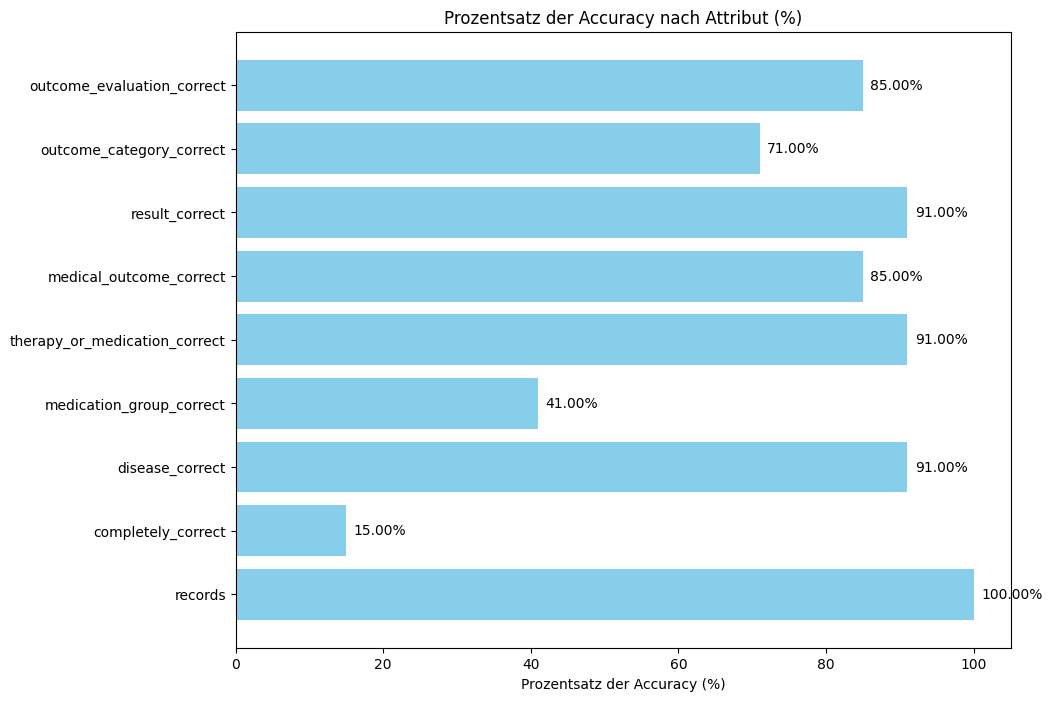

In [262]:
analysis_results_path = 'analysis_results.json'
magic_threshold = 0.75
is_magical = False

analysis_evaluation = evaluate_analysis_results(analysis_results_path, magic_threshold, is_magical)

print("Ergebnisse für", analysis_evaluation["records"], "Einträge")

max_wert = analysis_evaluation["records"]

prozent_werte = {key: (value / max_wert) * 100 for key, value in analysis_evaluation.items()}

plt.figure(figsize=(10, 8))
bars = plt.barh(list(prozent_werte.keys()), list(prozent_werte.values()), color='skyblue')
plt.xlabel('Prozentsatz der Accuracy (%)')
plt.title('Prozentsatz der Accuracy nach Attribut (%)')

for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}%', 
             va='center', ha='left', color='black')
plt.show()

Bis auf Medication Group wurden die anderen Attribute gut bis sehr gut vorhergesagt. Jedoch hat das Zusammenspiel nur bei jedem fünften Record geklappt, da completely_correct nur 19 % hat. Die Records waren nicht immer ganz identisch, sondern nur Teile davon.

Medical Outcome und Medikation wurden fast immer richtig vorhergesagt, was für Meta-Analysen sehr wichtig ist. Das Zusammenspiel mit Result ist hier ebenso wichtig, jedoch ist diese mit 72 % viel geringer.

Jeoch muss beachtet werden, dass die Dunkelziffer viel höher sein kann, da identische Ergebnisse manchmal eine sehr geringe Ähnlichkeit haben durch verschiedene Repräsentationen oder zusätzliche Wörter.

Alles in einem gute Ergebnisse und ein erfolgreiches Projekt.

Das hier ist jetzt quick and dirty geschrieben, eine bessere und genauere Diskussion der Ergebnisse ist im am Anfang erwähnten Paper zu finden.

## Lessons Learned

- **Tradeoff Similarity:** Hoher Threshold: Kleinere Accuracy dafür eindeutige Ergebnisse <-> Niedriger Threshold: Höhere Accuracy dafür weniger eindeutige Ergebnisse
- **Lange Analysen:** Ein kompletter Durchlauf bei so einer komplexen Analyse darf nicht unterschätzt werden. Bei nur knapp 1100 Paper wurden 12 Stunden gebraucht.

### Positiv
- LLaMa3 ist sehr schnell und liefert gute Ergebnisse
- Komplexe Texte können gut analysiert werden und das automatisiert sogar über einen längeren Zeitraum
- Die Einrichtung von LLaMa3 lokal ist dank OLLaMa sehr einfach
- Es gibt viele Libraries, mit denen sehr gut mit LLaMa programmiert werden
- Sehr viele Werkzeuge für viele unterschiedliche Anwendungsfälle
- Nutzung von ML-Modellen zur Bewältigung von komplexen Problemen und Fragen wie NLP
- Fehlersuche und Debugging über Logs
- Prompt Engineering ist ein Segen, da sie die Antworten verbessern kann
- Viele Medical Records konnten generiert werden mit guten Ergebnisse, die zukünftige Meta-Anaysen vereinfachen

### Negativ

- LLaMa2 ist sehr langsam und liefert keine guten Ergebnisse (Trotz Schema-Enforcing)
- Die Einrichtung von LLaMa2 lokal ist anstrengend (beim ersten mal)
- JSON, Dict, Liste und String sind painful zu handlen zusammen
- Library- und Versionsverwaltung in ML-Python-Projekten können sehr anstrengend sein
- Antworten der LLM sind manchmal schlecht oder zerreissen das Programm --> Kontermaßnahmen sind notwendig
- Vorgegebene Struktur wird nicht eingehalten oder JSON ist fehlerhaft (Key-Fehler, JSON inkorrekt)
- Vorgegebenes Format für die Attribute wurde manchmal nicht eingehalten, weshalb sie als nicht korrekt angesehen wurden, obwohl sie korrekt sind
- Null Werte werden zurückgegeben, trotz das gesagt wurde, dies nicht zu tun
- Unendliche Schleifen bei Fehlern
- Die Enumeration werden von LLaMa3 nicht eingehalten, neue Kategorien wurden dazu erfunden (sehr selten und diese waren auch den echten Kategorien sehr ähnlich)
- Prompt Engineering ist ein Fluch, da sie die Antworten auch fehlerhaft machen kann